# A Conceptual and Practical Introduction to Hilbert Space Gaussian Process (HSGP) Approximation Methods

## Prepare Notebook

In [1]:
from collections.abc import Callable

import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import preliz as pz
import pymc as pm
import seaborn as sns
from jax import random, vmap
from jaxlib.xla_extension import ArrayImpl
from numpyro.infer import MCMC, NUTS, Predictive
from pydantic import BaseModel, Field

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Generate Synthetic Data

In [2]:
def generate_synthetic_data(
    rng_key: ArrayImpl, start: float, stop: float, num: int, scale: float
) -> tuple[ArrayImpl, ArrayImpl, ArrayImpl]:
    x = jnp.linspace(start=start, stop=stop, num=num)
    y = jnp.sin(4 * jnp.pi * x) + jnp.sin(7 * jnp.pi * x)
    y_obs = y + scale * random.normal(rng_key, shape=(num,))
    return x, y, y_obs


n_train = 80
n_test = 100
scale = 0.3

rng_key, rng_subkey = random.split(rng_key)
x_train, y_train, y_train_obs = generate_synthetic_data(
    rng_key=rng_subkey, start=0, stop=1, num=n_train, scale=scale
)

rng_key, rng_subkey = random.split(rng_key)
x_test, y_test, y_test_obs = generate_synthetic_data(
    rng_key=rng_subkey, start=-0.2, stop=1.2, num=n_test, scale=scale
)

Text(0.5, 1.0, 'Synthetic Data')

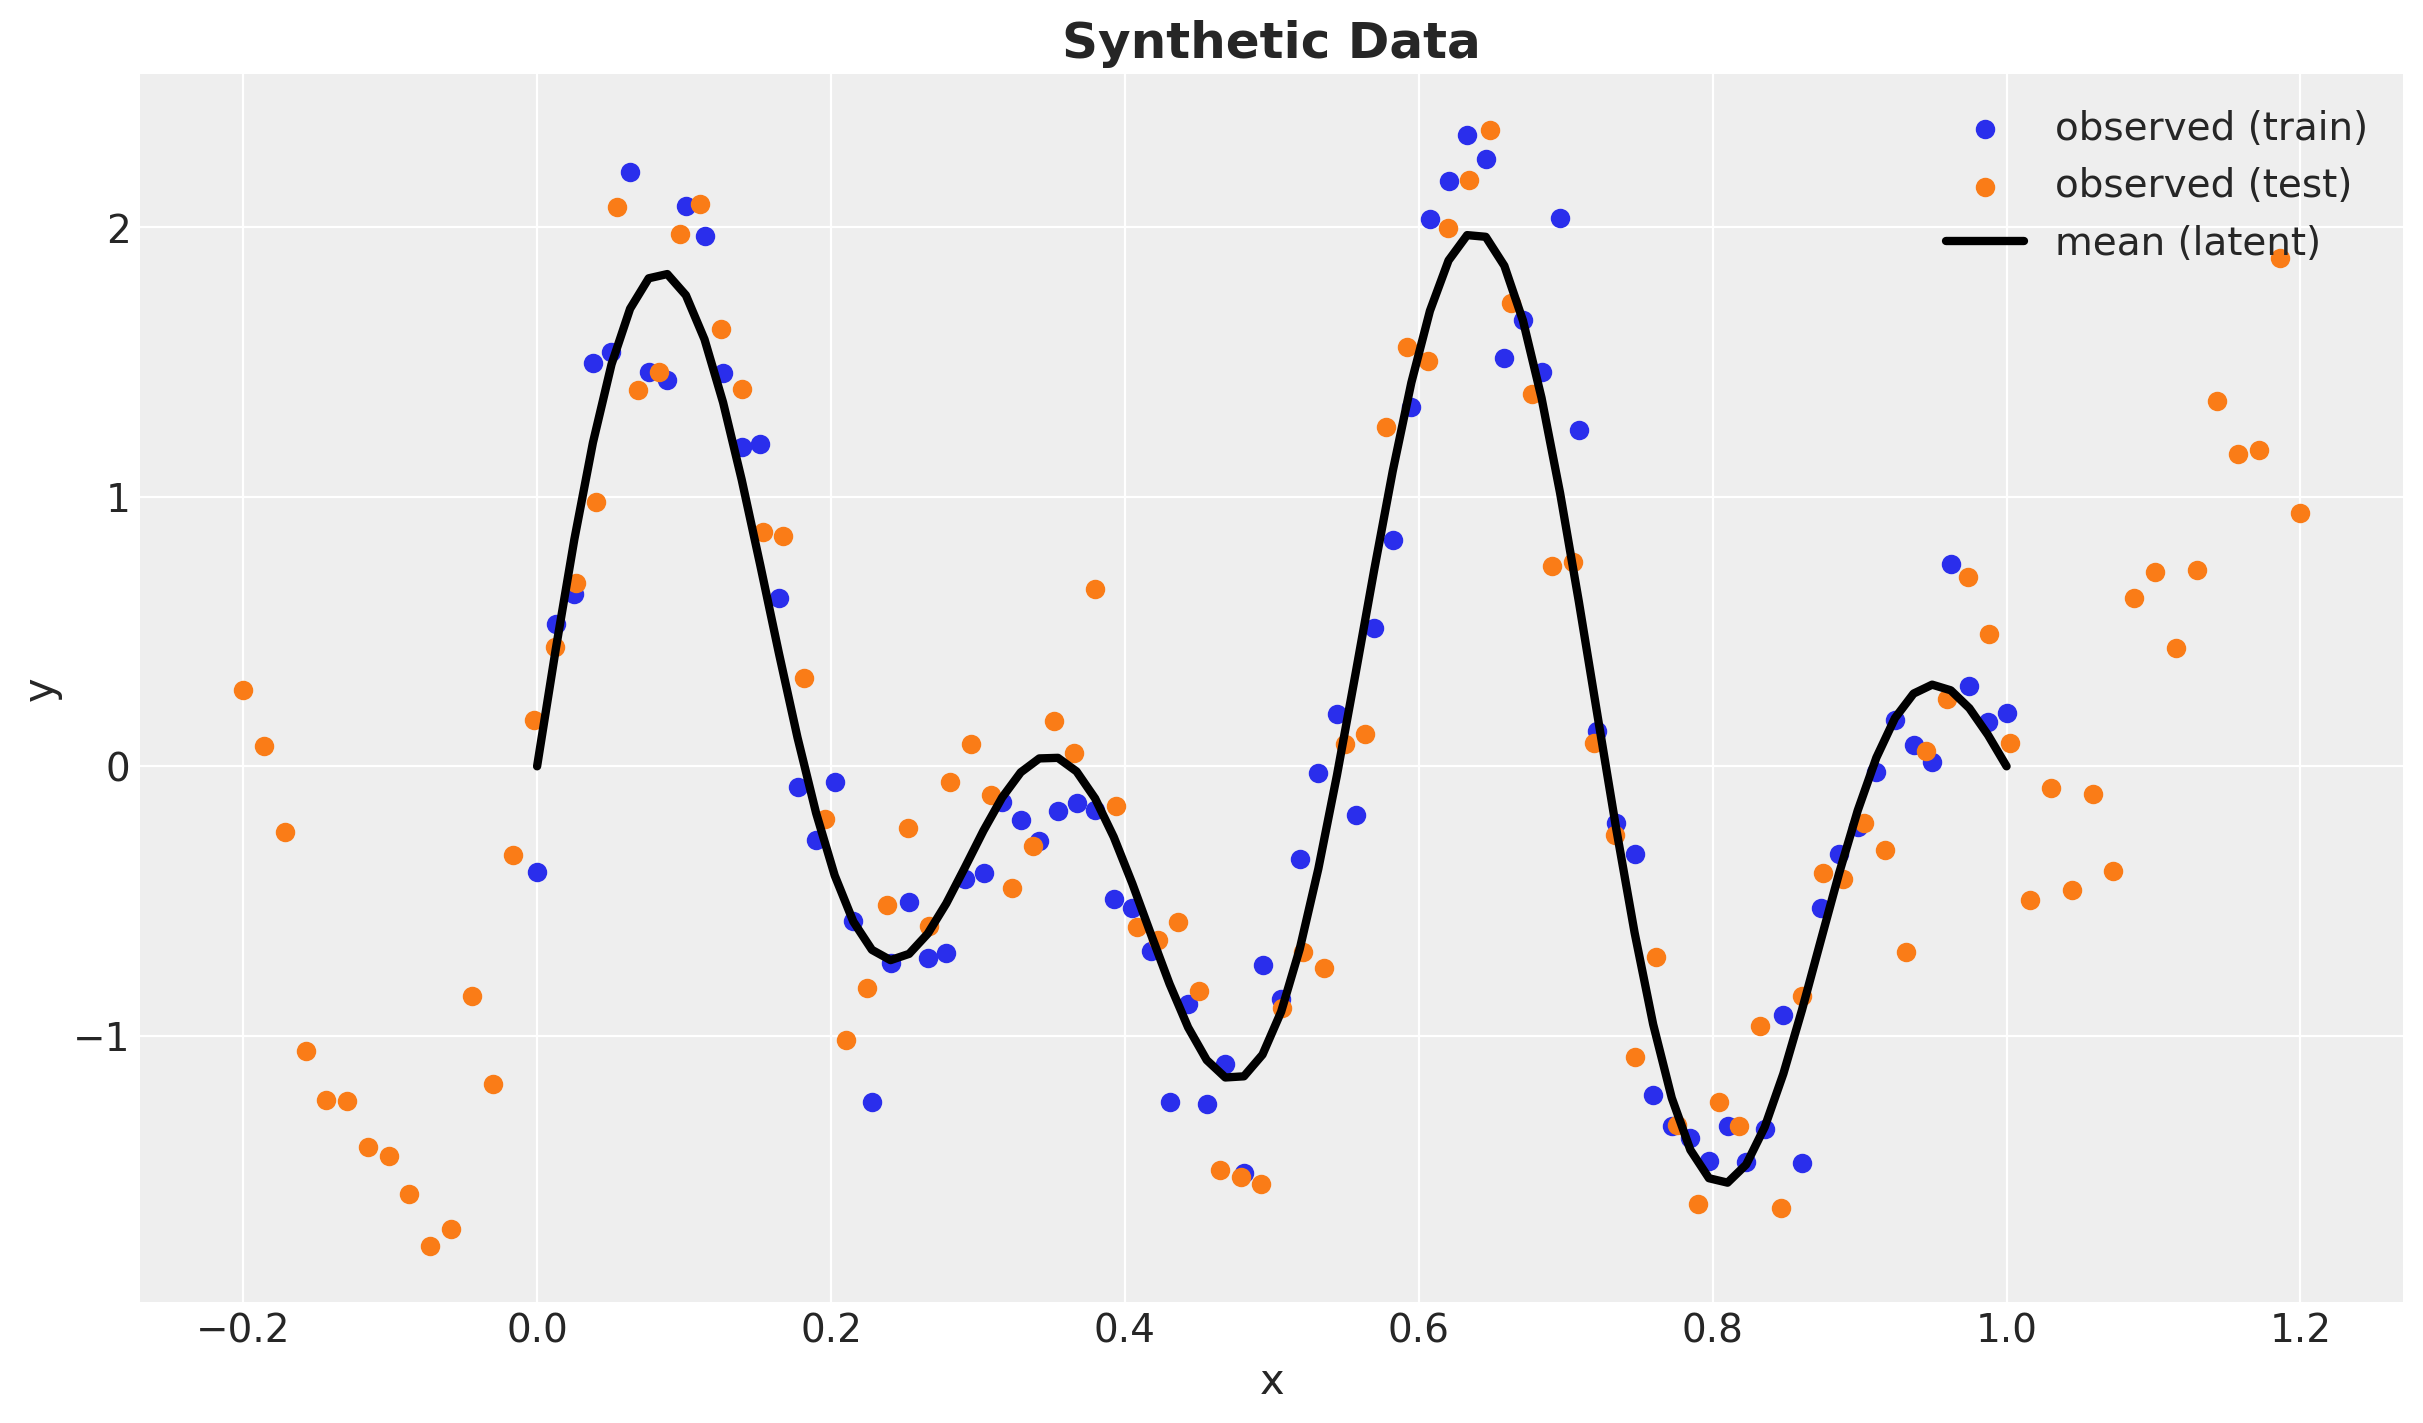

In [3]:
fig, ax = plt.subplots()
ax.scatter(x_train, y_train_obs, c="C0", label="observed (train)")
ax.scatter(x_test, y_test_obs, c="C1", label="observed (test)")
ax.plot(x_train, y_train, color="black", linewidth=3, label="mean (latent)")
ax.legend(loc="upper right")
ax.set(xlabel="x", ylabel="y")

ax.set_title("Synthetic Data", fontsize=18, fontweight="bold")

---

# Part I: Gaussian Processes (GPs)

## NumPyro Gaussian Process Model

### Kernel Specification

$$
\text{cov}(f(x_p), f(x_q)) = k_{\sigma_f, \ell}(x_p, x_q) = \sigma_f \exp\left(-\frac{1}{2\ell^2} ||x_p - x_q||^2\right)
$$

In [4]:
# https://num.pyro.ai/en/stable/examples/gp.html
def squared_exponential_kernel(
    xp: ArrayImpl, xq: ArrayImpl, amplitude: float, length_scale: float
) -> ArrayImpl:
    r = xp[:, None] - xq[None, :]
    delta = (r / length_scale) ** 2
    return amplitude**2 * jnp.exp(-0.5 * delta)

In [5]:
k = squared_exponential_kernel(x_train, x_train, amplitude=1.0, length_scale=0.1)

assert (k == k.T).all().item()
assert (jnp.diag(k) == 1).all().item()
# chol, _ = linalg.cho_factor(k)
# np.linalg.cholesky(k)

Text(0.5, 1.0, 'Squared Exponential Kernel')

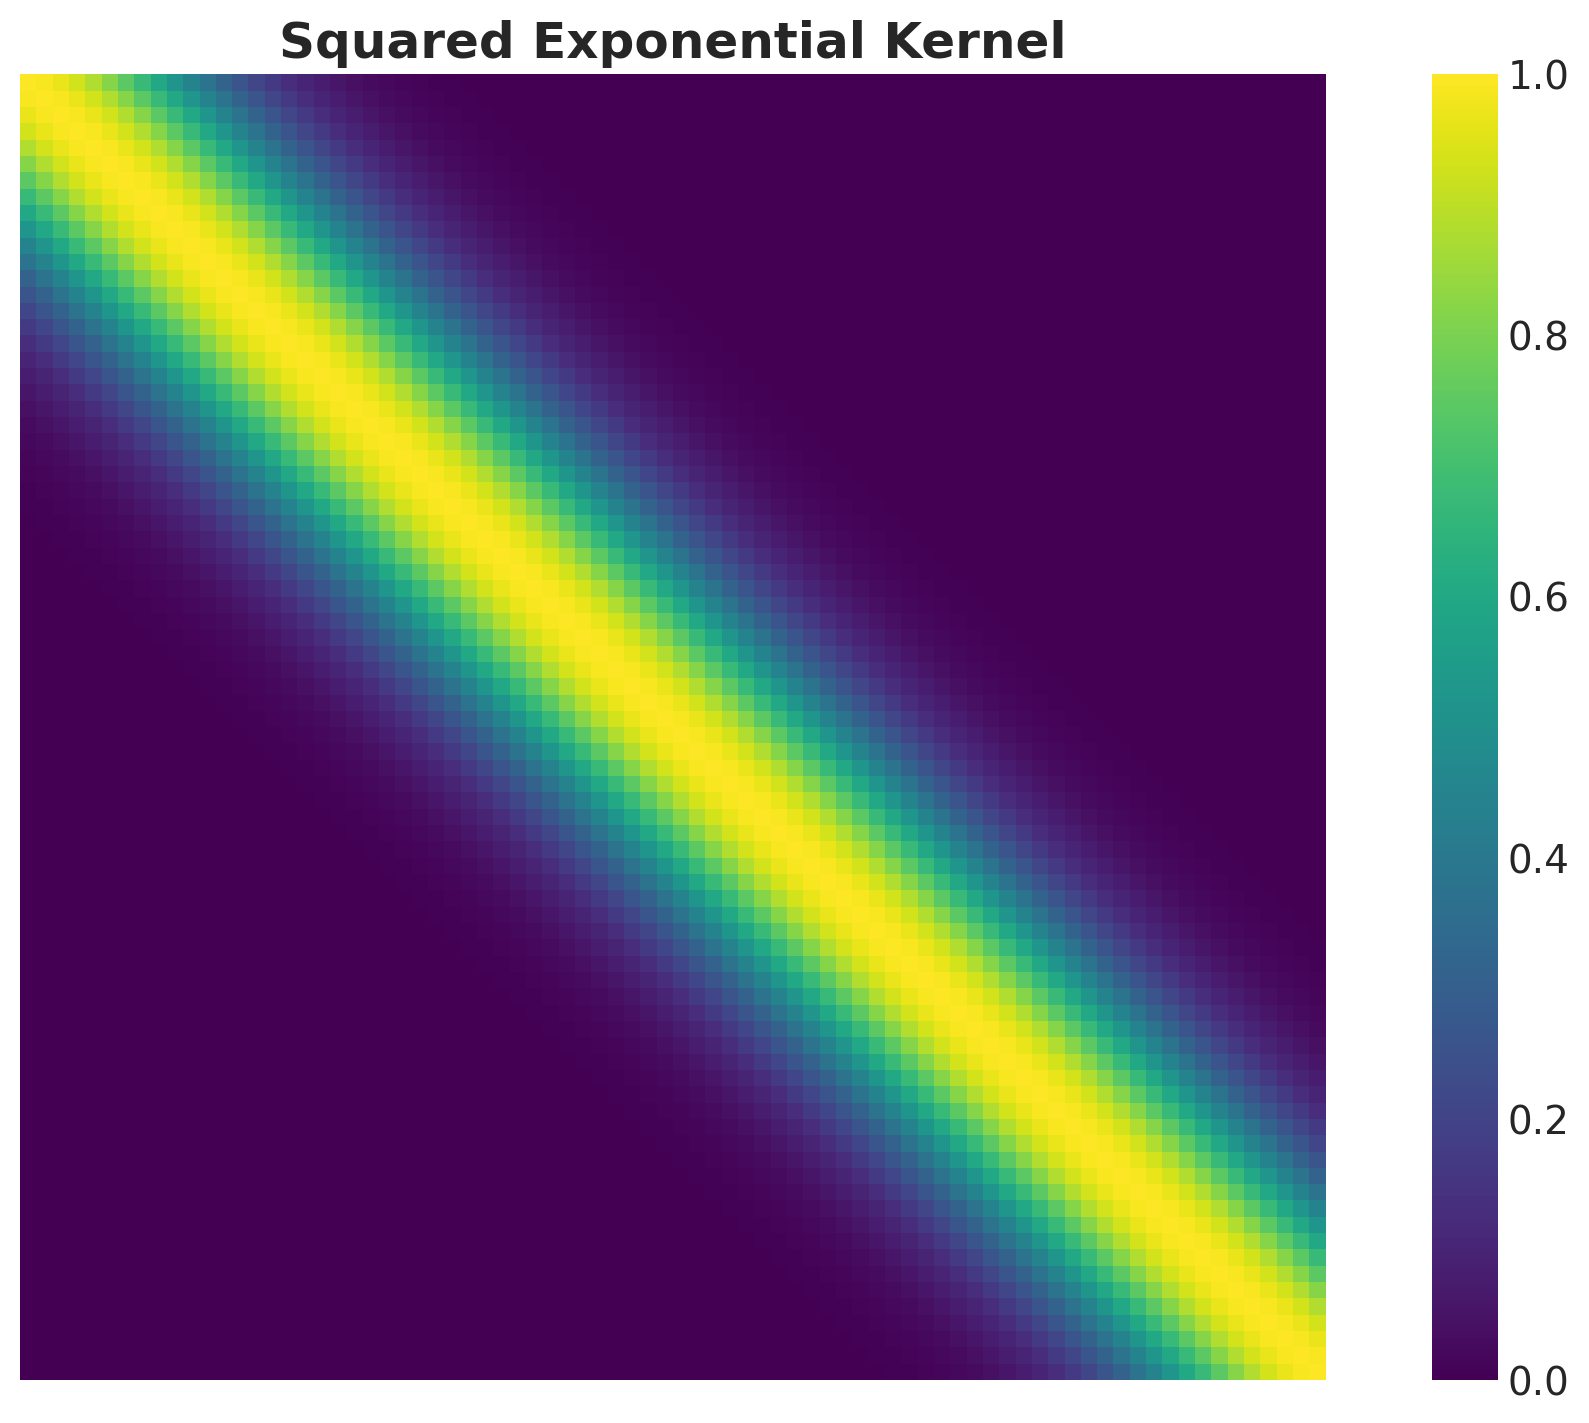

In [6]:
fig, ax = plt.subplots()
sns.heatmap(
    data=k,
    square=True,
    cmap="viridis",
    cbar=True,
    xticklabels=False,
    yticklabels=False,
    ax=ax,
)
ax.set_title("Squared Exponential Kernel", fontsize=18, fontweight="bold")

### Parameter Priors

Text(0.5, 1.0, 'Prior Distributions')

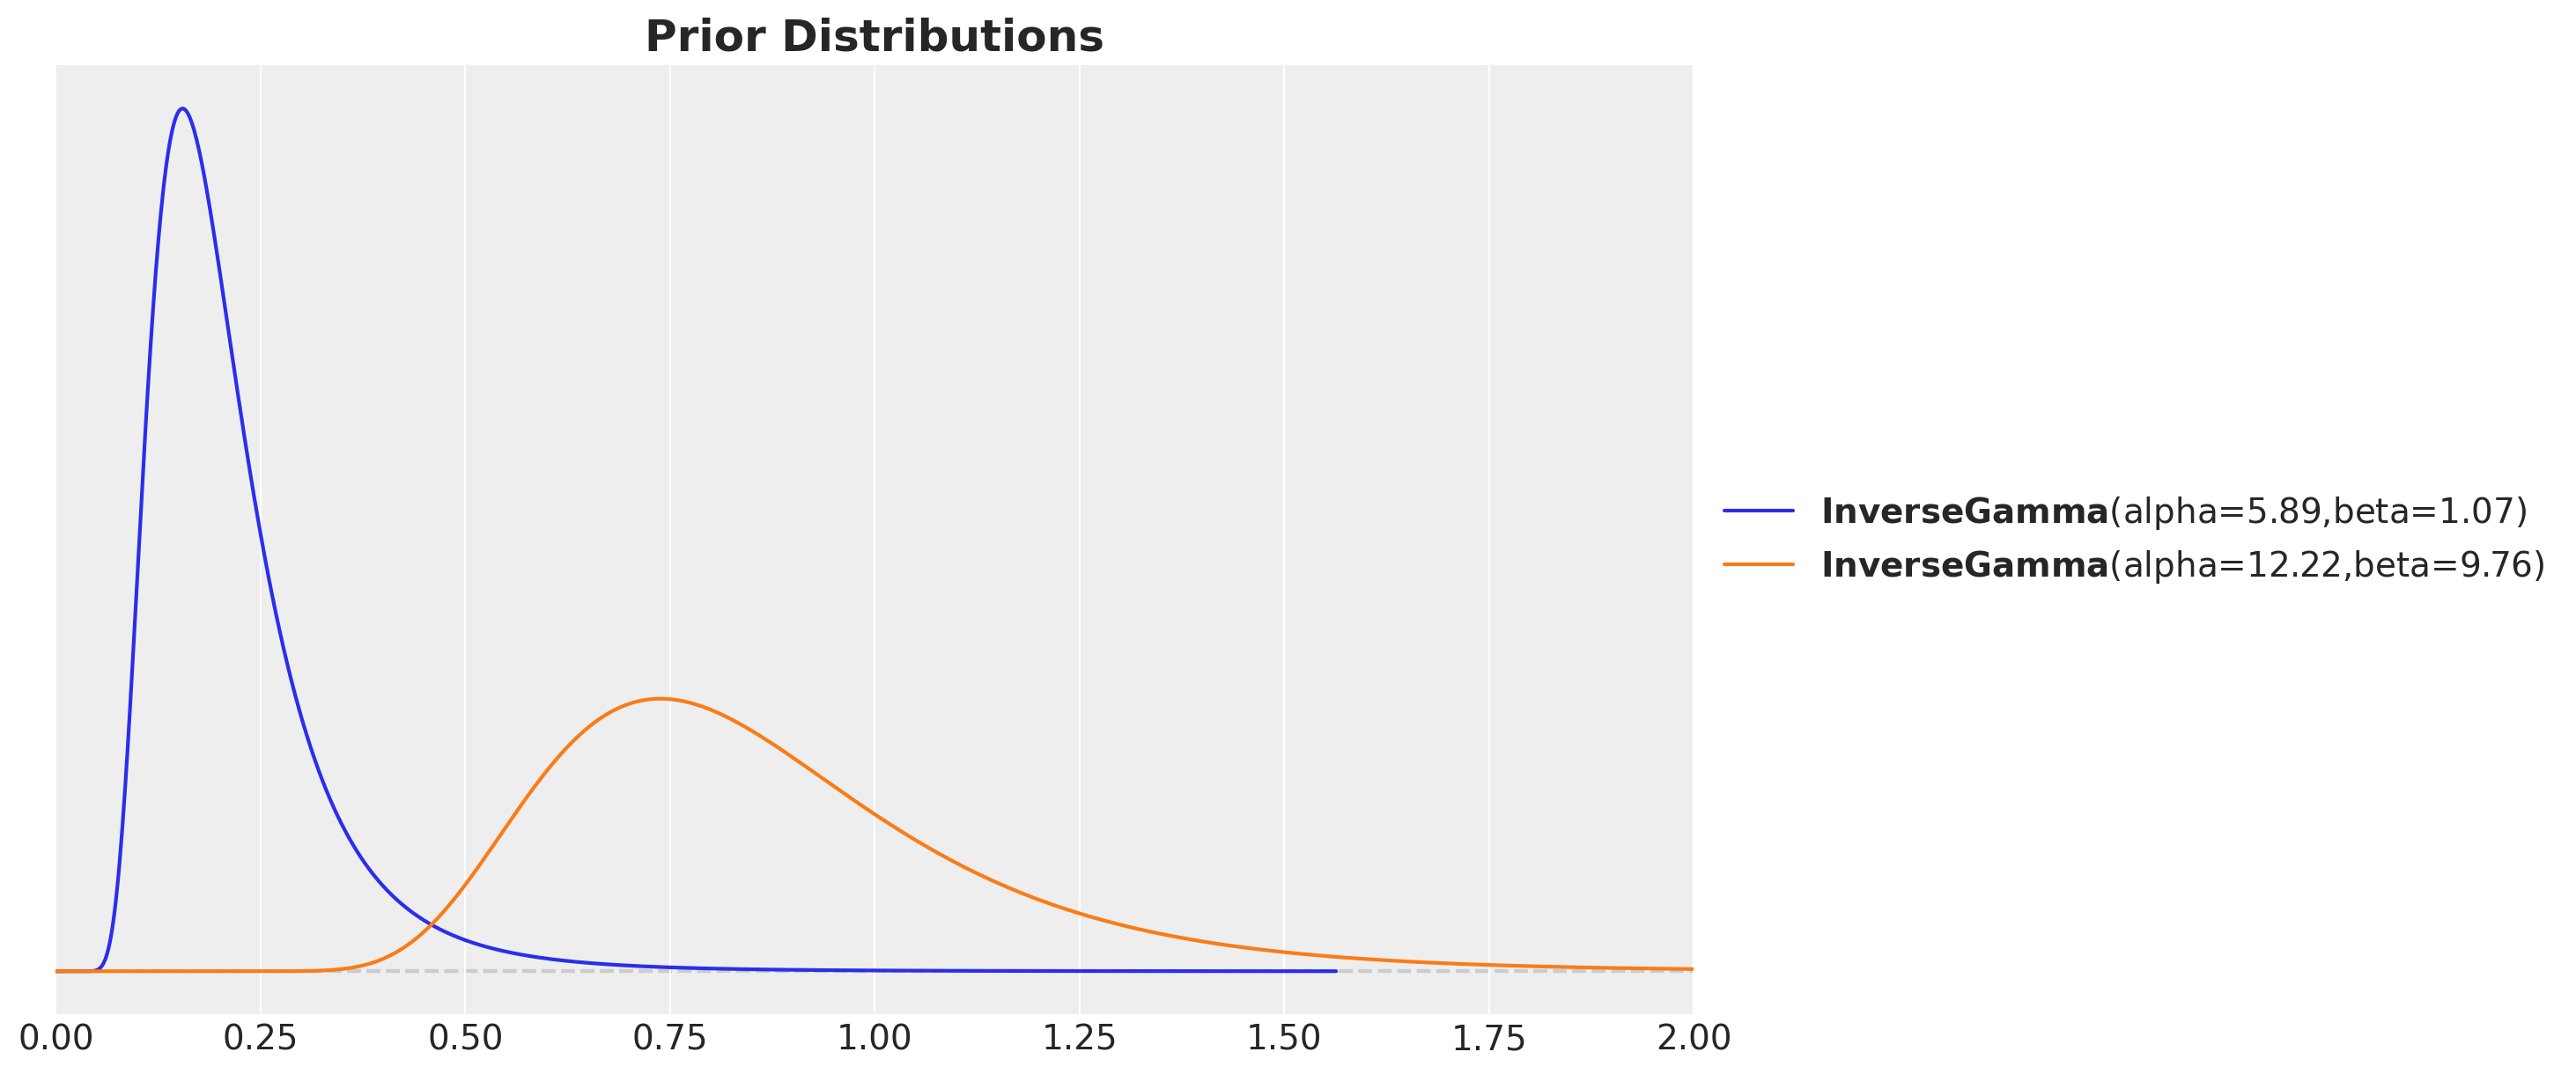

In [7]:
inverse_gamma_params_1 = pm.find_constrained_prior(
    distribution=pm.InverseGamma,
    lower=0.01,
    upper=0.4,
    init_guess={"alpha": 5, "beta": 3},
    mass=0.94,
)
inverse_gamma_params_2 = pm.find_constrained_prior(
    distribution=pm.InverseGamma,
    lower=0.5,
    upper=1.5,
    init_guess={"alpha": 5, "beta": 6},
    mass=0.94,
)

fig, ax = plt.subplots()
pz.InverseGamma(**inverse_gamma_params_1).plot_pdf(color="C0", ax=ax)
pz.InverseGamma(**inverse_gamma_params_2).plot_pdf(color="C1", ax=ax)
ax.set(xlim=(0, 2))
ax.set_title("Prior Distributions", fontsize=18, fontweight="bold")

### Model Specification

In [8]:
def gp_model(x, y=None, jitter=1.0e-6) -> None:
    # --- Priors ---
    kernel_amplitude = numpyro.sample(
        "kernel_amplitude",
        dist.InverseGamma(
            concentration=inverse_gamma_params_2["alpha"],
            rate=inverse_gamma_params_2["beta"],
        ),
    )
    kernel_length_scale = numpyro.sample(
        "kernel_length_scale",
        dist.InverseGamma(
            concentration=inverse_gamma_params_1["alpha"],
            rate=inverse_gamma_params_1["beta"],
        ),
    )
    noise = numpyro.sample(
        "noise",
        dist.InverseGamma(
            concentration=inverse_gamma_params_2["alpha"],
            rate=inverse_gamma_params_2["beta"],
        ),
    )
    # --- Parametrization ---
    mean = jnp.zeros(x.shape[0])
    kernel = squared_exponential_kernel(x, x, kernel_amplitude, kernel_length_scale)
    covariance_matrix = kernel + (noise + jitter) * jnp.eye(x.shape[0])
    # --- Likelihood ---
    numpyro.sample(
        "likelihood",
        dist.MultivariateNormal(loc=mean, covariance_matrix=covariance_matrix),
        obs=y,
    )

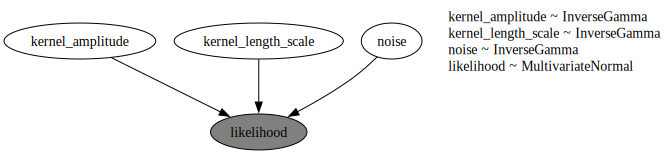

In [9]:
numpyro.render_model(
    model=gp_model,
    model_args=(x_train, y_train_obs),
    render_distributions=True,
    render_params=True,
)

### Prior Predictive Check

In [10]:
gp_numpyro_prior_predictive = Predictive(gp_model, num_samples=1_000)
rng_key, rng_subkey = random.split(rng_key)
gp_numpyro_prior_samples = gp_numpyro_prior_predictive(rng_subkey, x_train)

gp_numpyro_prior_idata = az.from_numpyro(prior=gp_numpyro_prior_samples)

Text(0.5, 1.0, 'GP NumPyro Model - Prior Predictive')

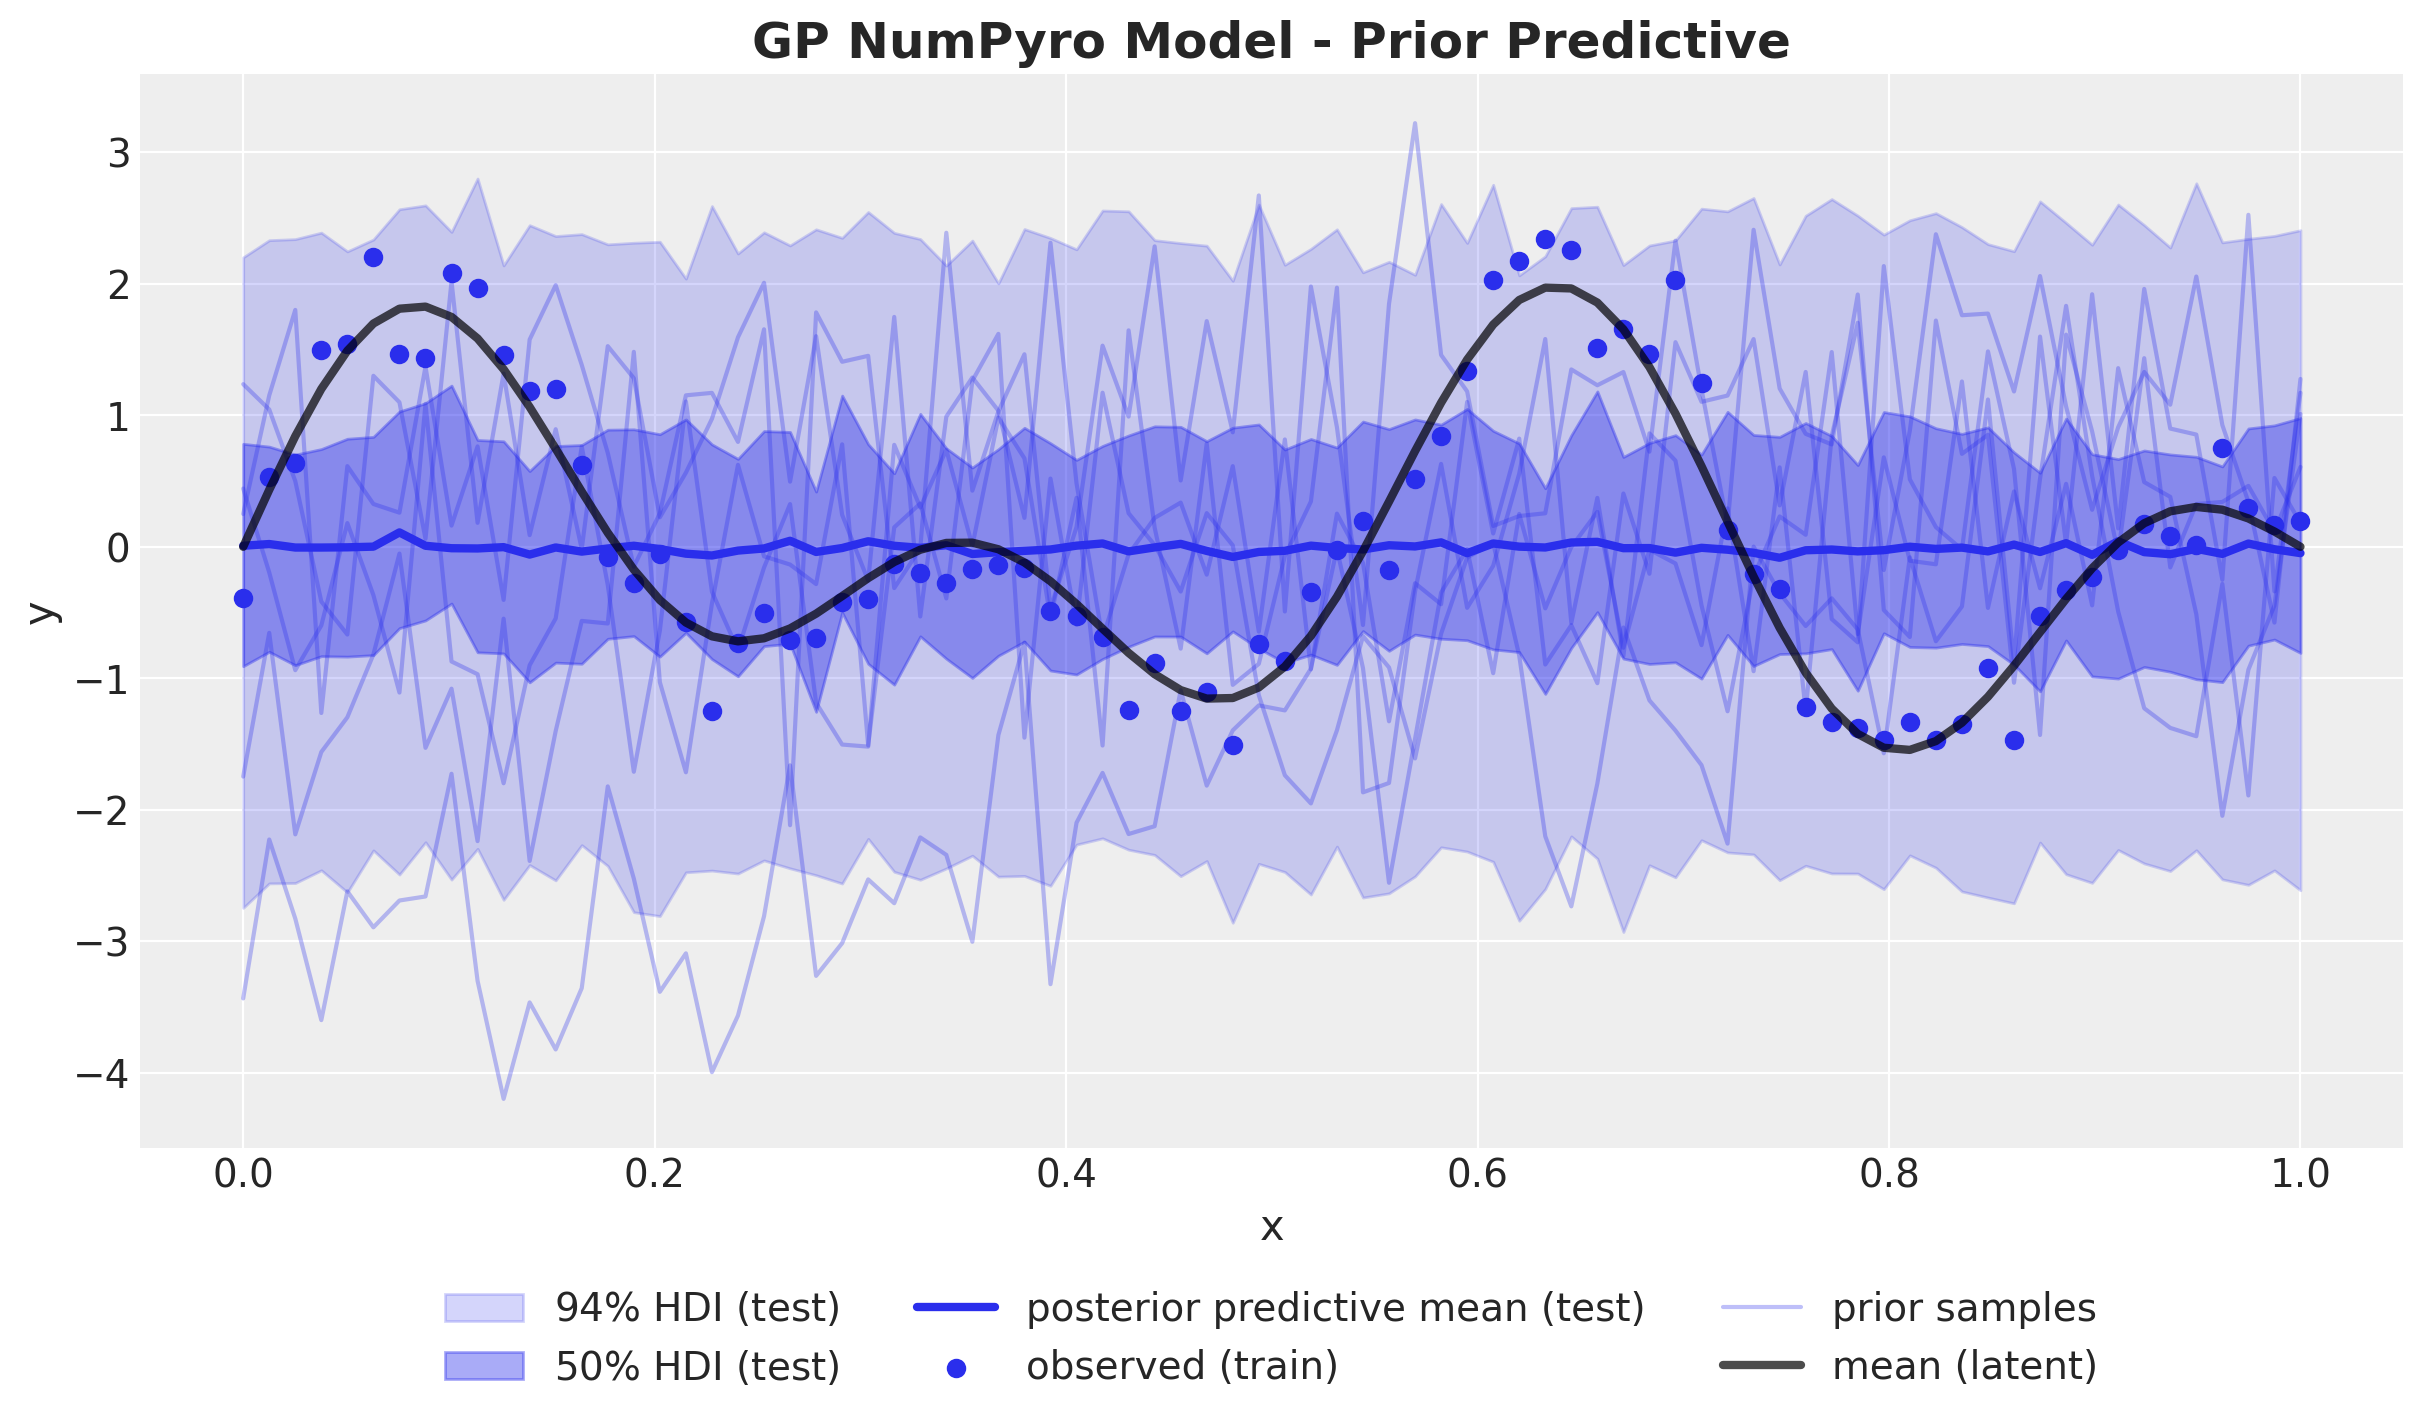

In [11]:
fig, ax = plt.subplots()
az.plot_hdi(
    x_train,
    gp_numpyro_prior_idata.prior["likelihood"],
    hdi_prob=0.94,
    color="C0",
    smooth=False,
    fill_kwargs={"alpha": 0.2, "label": "$94\\%$ HDI (test)"},
    ax=ax,
)
az.plot_hdi(
    x_train,
    gp_numpyro_prior_idata.prior["likelihood"],
    hdi_prob=0.5,
    color="C0",
    smooth=False,
    fill_kwargs={"alpha": 0.4, "label": "$50\\%$ HDI (test)"},
    ax=ax,
)
ax.plot(
    x_train,
    gp_numpyro_prior_idata.prior["likelihood"].mean(dim=("chain", "draw")),
    color="C0",
    linewidth=3,
    label="posterior predictive mean (test)",
)
ax.scatter(x_train, y_train_obs, c="C0", label="observed (train)")
for i in range(5):
    label = "prior samples" if i == 0 else None
    ax.plot(
        x_train,
        gp_numpyro_prior_idata.prior["likelihood"].sel(chain=0, draw=i),
        color="C0",
        alpha=0.3,
        label=label,
    )
ax.plot(x_train, y_train, color="black", linewidth=3, alpha=0.7, label="mean (latent)")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3)
ax.set(xlabel="x", ylabel="y")
ax.set_title("GP NumPyro Model - Prior Predictive", fontsize=18, fontweight="bold")

### Model Fitting

In [12]:
class InferenceParams(BaseModel):
    num_warmup: int = Field(2_000, ge=1)
    num_samples: int = Field(2_000, ge=1)
    num_chains: int = Field(4, ge=1)


def run_inference(
    rng_key: ArrayImpl,
    model: Callable,
    args: InferenceParams,
    *model_args,
    **nuts_kwargs,
) -> MCMC:
    sampler = NUTS(model, **nuts_kwargs)
    mcmc = MCMC(
        sampler=sampler,
        num_warmup=args.num_warmup,
        num_samples=args.num_samples,
        num_chains=args.num_chains,
    )
    mcmc.run(rng_key, *model_args)
    return mcmc


inference_params = InferenceParams()
rng_key, rng_subkey = random.split(key=rng_key)
gp_mcmc = run_inference(rng_subkey, gp_model, inference_params, x_train, y_train_obs)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

### Model Diagnostics

In [13]:
gp_numpyro_idata = az.from_numpyro(posterior=gp_mcmc)

az.summary(data=gp_numpyro_idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
kernel_amplitude,1.190,0.267,0.729,1.672,0.004,0.003,5426.0,4562.0,1.0
kernel_length_scale,0.089,0.011,0.069,0.109,0.000,0.000,5004.0,4967.0,1.0
noise,0.278,0.043,0.204,0.359,0.001,0.000,5928.0,4826.0,1.0


Text(0.5, 0.98, 'GP NumPyro - Trace')

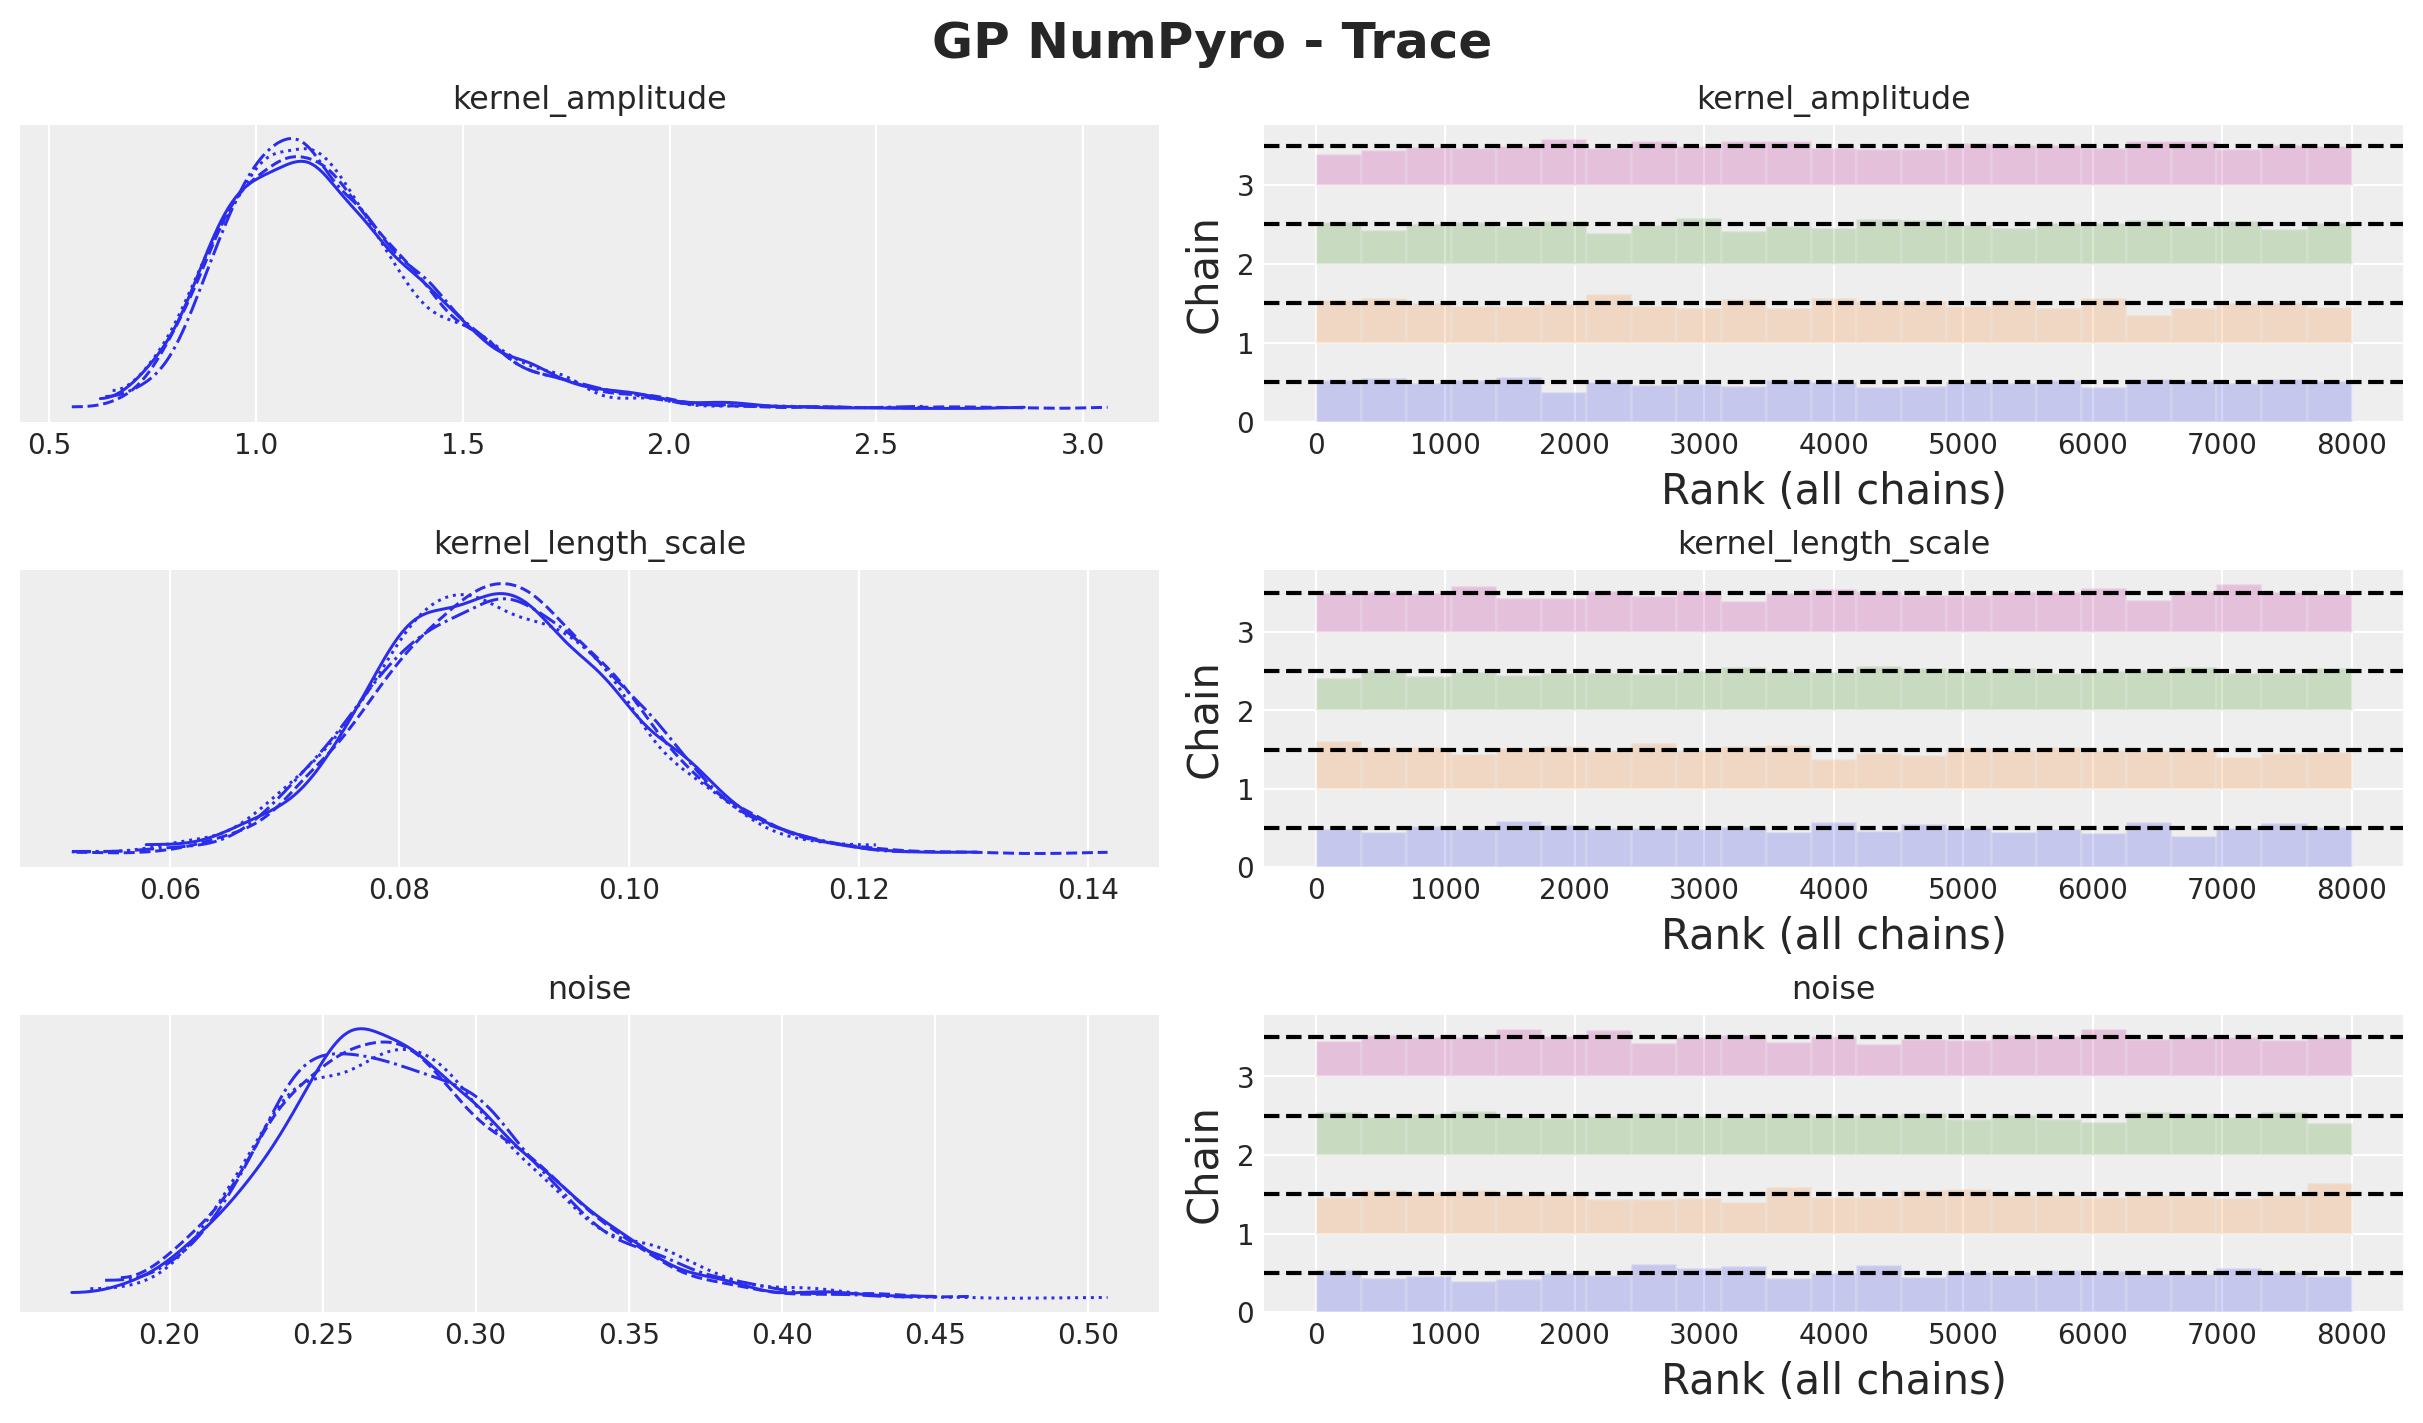

In [14]:
axes = az.plot_trace(
    data=gp_numpyro_idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 7), "layout": "constrained"},
)
plt.gcf().suptitle("GP NumPyro - Trace", fontsize=18, fontweight="bold")

### Out of Sample Prediction

The joint distribution  of \\(y\\) and \\(f_*\\) is given by 

$$
\left(
\begin{array}{c}
y \\
f_*
\end{array}
\right)
\sim
\text{MultivariateNormal}(0, C)
$$

where 

$$
C = 
\left(
\begin{array}{cc}
K(X, X) + \sigma^2_n I & K(X, X_*) \\
K(X_*, X) & K(X_*, X_*)
\end{array}
\right)
$$

Observe that we need to add the term $\sigma^2_n I$ to the upper left component to account for noise (assuming additive independent identically distributed Gaussian noise). We now compute the matrix $C$.

As described in our main reference, *to get the posterior distribution over functions we need to restrict this joint
prior distribution to contain only those functions which agree with the observed
data points*, that is, we are interested in computing $f_*|X, y, X_*$. Using the results of [Gaussian Processes for Machine Learning, Appendinx A.2](http://www.gaussianprocess.org/gpml/chapters/RWA.pdf), one can show that 

$$
f_*|X, y, X_* 
\sim
N(\bar{f}_*, \text{cov}(f_*))
$$

where 

$$
\bar{f}_* = K(X_*, X)(K(X, X) + \sigma^2_n I)^{-1} y \in \mathbb{R}^{n_*}
$$

and 

$$
\text{cov}(f_*) = K(X_*, X_*) - K(X_*, X)(K(X, X) + \sigma^2_n I)^{-1} K(X, X_*) \in M_{n_*}(\mathbb{R})
$$

In [15]:
def get_kernel_matrices_train_test(
    kernel, x, x_test, noise, jitter=1.0e-6, **kernel_kwargs
) -> tuple[ArrayImpl, ArrayImpl, ArrayImpl]:
    k = kernel(x, x, **kernel_kwargs) + (noise + jitter) * jnp.eye(x.shape[0])
    k_star = kernel(x_test, x, **kernel_kwargs)
    k_star_star = kernel(x_test, x_test, **kernel_kwargs) + (noise + jitter) * jnp.eye(
        x_test.shape[0]
    )
    return k, k_star, k_star_star


def sample_test(rng_key, kernel, x, y, x_test, noise, jitter=1.0e-6, **kernel_kwargs):
    k, k_star, k_star_star = get_kernel_matrices_train_test(
        kernel, x, x_test, noise, jitter, **kernel_kwargs
    )
    k_inv = jnp.linalg.inv(k)
    mean_star = k_star @ (k_inv @ y)
    cov_star = k_star_star - (k_star @ k_inv @ k_star.T)
    return random.multivariate_normal(rng_key, mean=mean_star, cov=cov_star)

In [16]:
rng_key, rng_subkey = random.split(rng_key)

vmap_args = (
    random.split(
        rng_subkey, inference_params.num_samples * inference_params.num_chains
    ),
    gp_mcmc.get_samples()["noise"],
    gp_mcmc.get_samples()["kernel_amplitude"],
    gp_mcmc.get_samples()["kernel_length_scale"],
)

posterior_predictive_test = vmap(
    lambda rng_key, noise, amplitude, length_scale: sample_test(
        rng_key,
        squared_exponential_kernel,
        x_train,
        y_train_obs,
        x_test,
        noise,
        amplitude=amplitude,
        length_scale=length_scale,
    ),
)(*vmap_args)

gp_numpyro_idata.extend(
    az.from_dict(
        posterior_predictive={
            "y_pred_test": posterior_predictive_test[None, ...],
        },
        coords={"x": x_test},
        dims={"y_pred_test": ["x"]},
    )
)

Text(0.5, 1.0, 'GP NumPyro Model - Posterior Predictive')

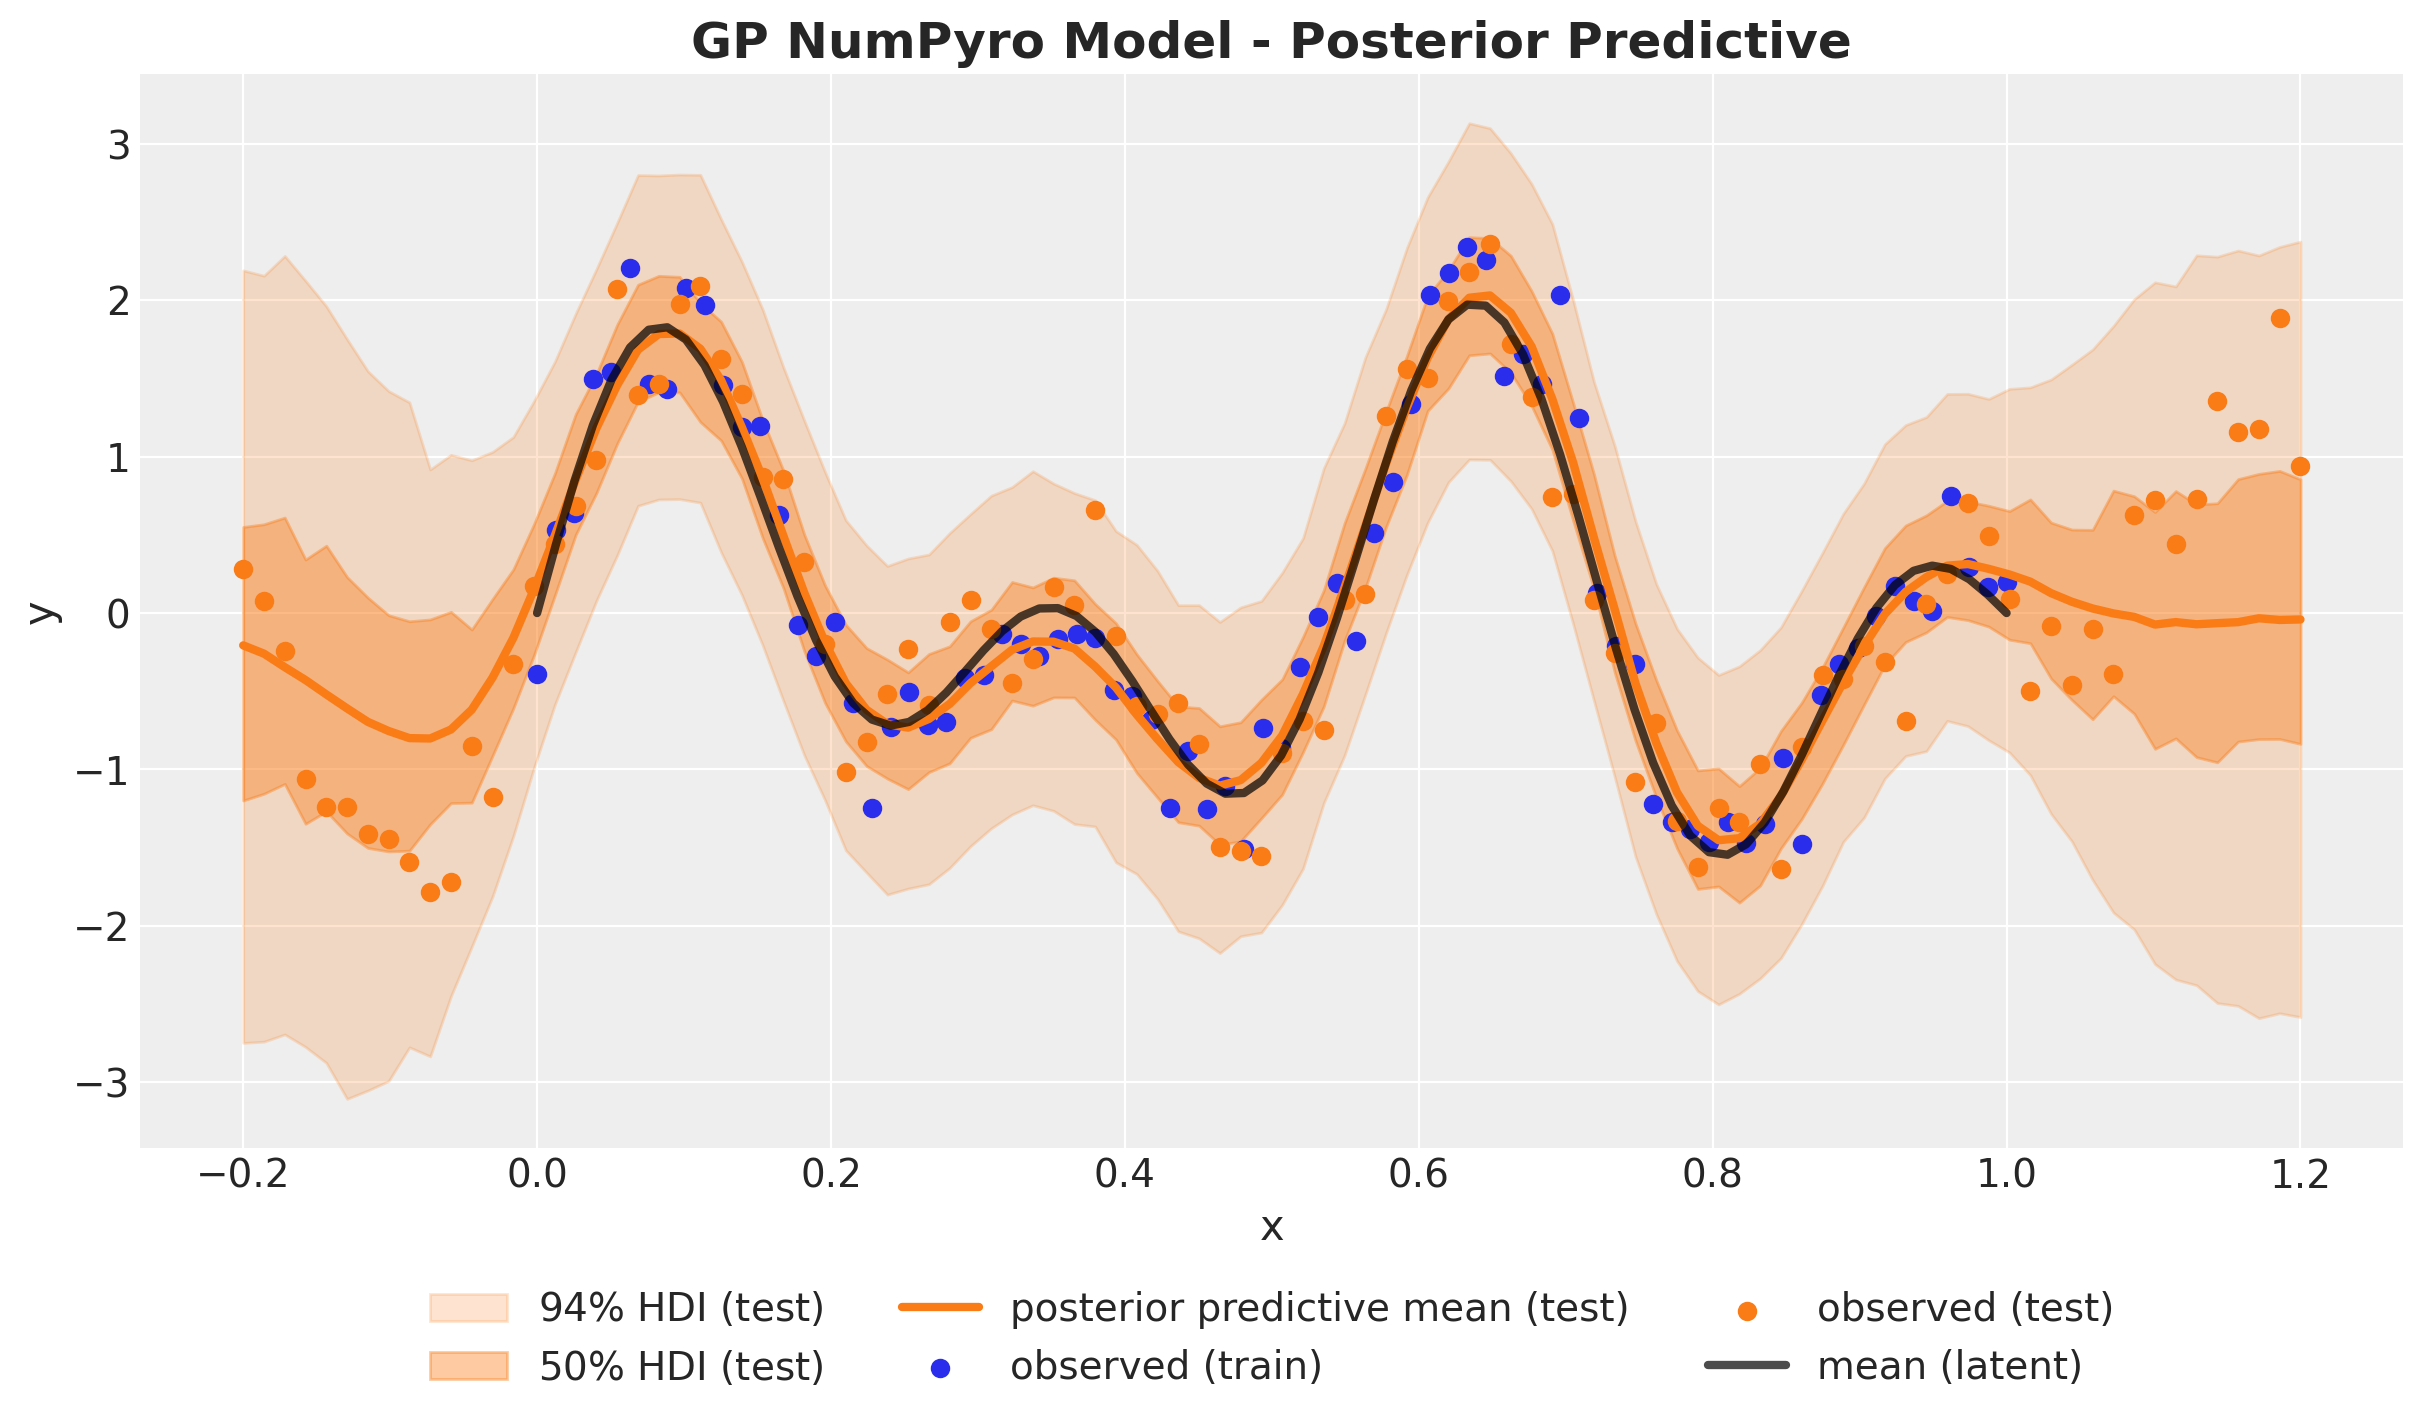

In [17]:
fig, ax = plt.subplots()
az.plot_hdi(
    x_test,
    gp_numpyro_idata.posterior_predictive["y_pred_test"],
    hdi_prob=0.94,
    color="C1",
    smooth=False,
    fill_kwargs={"alpha": 0.2, "label": "$94\\%$ HDI (test)"},
    ax=ax,
)
az.plot_hdi(
    x_test,
    gp_numpyro_idata.posterior_predictive["y_pred_test"],
    hdi_prob=0.5,
    color="C1",
    smooth=False,
    fill_kwargs={"alpha": 0.4, "label": "$50\\%$ HDI (test)"},
    ax=ax,
)
ax.plot(
    x_test,
    gp_numpyro_idata.posterior_predictive["y_pred_test"].mean(dim=("chain", "draw")),
    color="C1",
    linewidth=3,
    label="posterior predictive mean (test)",
)
ax.scatter(x_train, y_train_obs, c="C0", label="observed (train)")
ax.scatter(x_test, y_test_obs, c="C1", label="observed (test)")
ax.plot(x_train, y_train, color="black", linewidth=3, alpha=0.7, label="mean (latent)")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3)
ax.set(xlabel="x", ylabel="y")
ax.set_title("GP NumPyro Model - Posterior Predictive", fontsize=18, fontweight="bold")

## PyMC Gaussian Process Model

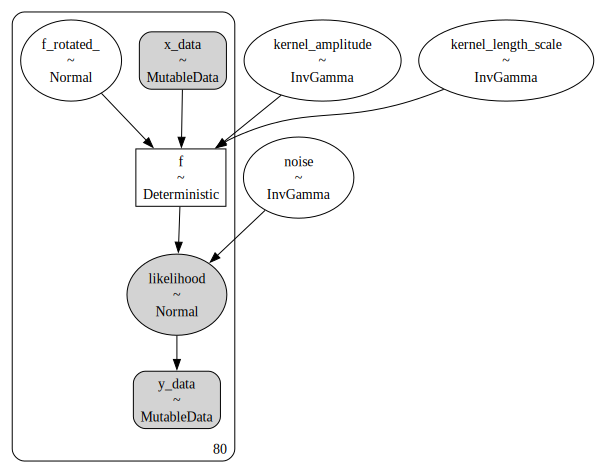

In [18]:
with pm.Model() as gp_pymc_model:
    x_data = pm.MutableData("x_data", value=x_train)
    y_data = pm.MutableData("y_data", value=y_train_obs)

    kernel_amplitude = pm.InverseGamma(
        "kernel_amplitude",
        alpha=inverse_gamma_params_2["alpha"],
        beta=inverse_gamma_params_2["beta"],
    )
    kernel_length_scale = pm.InverseGamma(
        "kernel_length_scale",
        alpha=inverse_gamma_params_1["alpha"],
        beta=inverse_gamma_params_1["beta"],
    )
    noise = pm.InverseGamma(
        "noise",
        alpha=inverse_gamma_params_2["alpha"],
        beta=inverse_gamma_params_2["beta"],
    )

    mean = pm.gp.mean.Zero()
    cov = kernel_amplitude**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=kernel_length_scale)
    gp = pm.gp.Latent(mean_func=mean, cov_func=cov)
    f = gp.prior("f", X=x_data[:, None])

    pm.Normal("likelihood", mu=f, sigma=noise, observed=y_data)


pm.model_to_graphviz(model=gp_pymc_model)

In [19]:
rng_key, rng_subkey = random.split(rng_key)

with gp_pymc_model:
    gp_pymc_idata = pm.sample(
        target_accept=0.9,
        draws=inference_params.num_samples,
        chains=inference_params.num_chains,
        nuts_sampler="numpyro",
        random_seed=rng_subkey[0].item(),
    )

Compiling...
Compilation time = 0:00:03.323142
Sampling...


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time = 0:04:54.085760
Transforming variables...
Transformation time = 0:00:01.469478


Text(0.5, 0.98, 'GP PyMC - Trace')

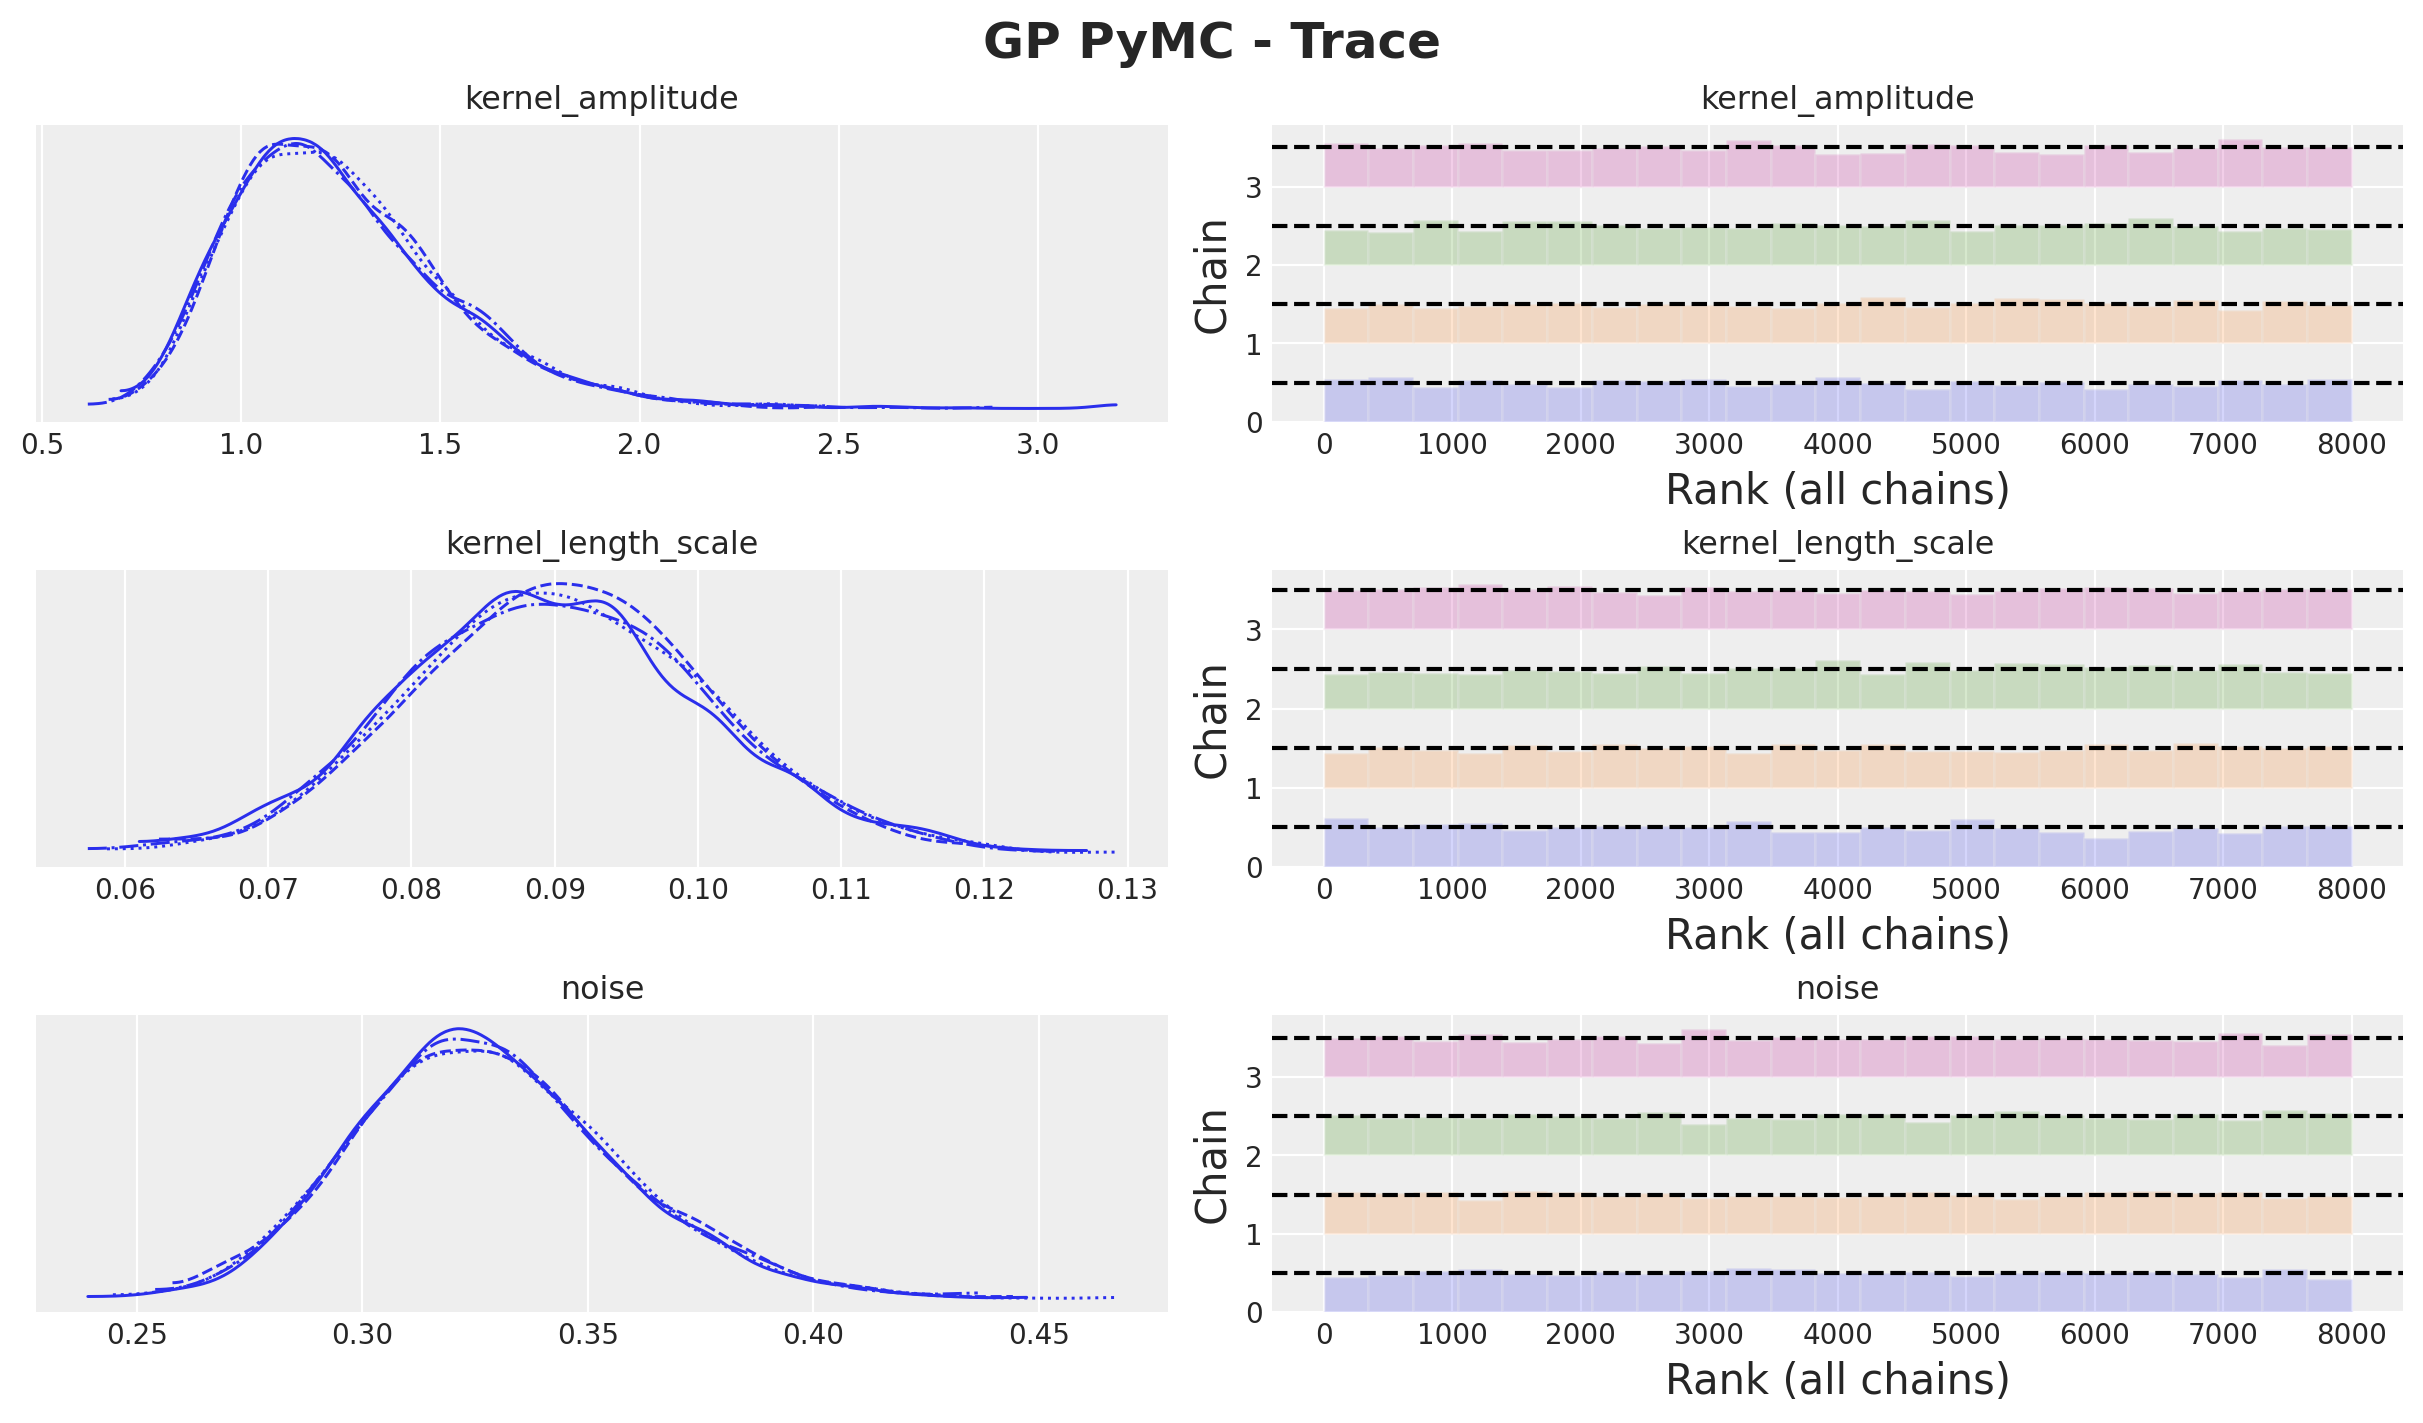

In [20]:
axes = az.plot_trace(
    data=gp_pymc_idata,
    var_names=["kernel_amplitude", "kernel_length_scale", "noise"],
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 7), "layout": "constrained"},
)
plt.gcf().suptitle("GP PyMC - Trace", fontsize=18, fontweight="bold")

In [21]:
with gp_pymc_model:
    x_star_data = pm.MutableData("x_star_data", x_test)
    y_pred_test = gp.conditional("y_pred_test", x_star_data[:, None])
    gp_pymc_idata.extend(
        pm.sample_posterior_predictive(
            trace=gp_pymc_idata,
            var_names=["y_pred_test"],
            random_seed=rng_subkey[1].item(),
        )
    )

Sampling: [y_pred_test]


Text(0.5, 1.0, 'GP PyMC Model - Posterior Predictive')

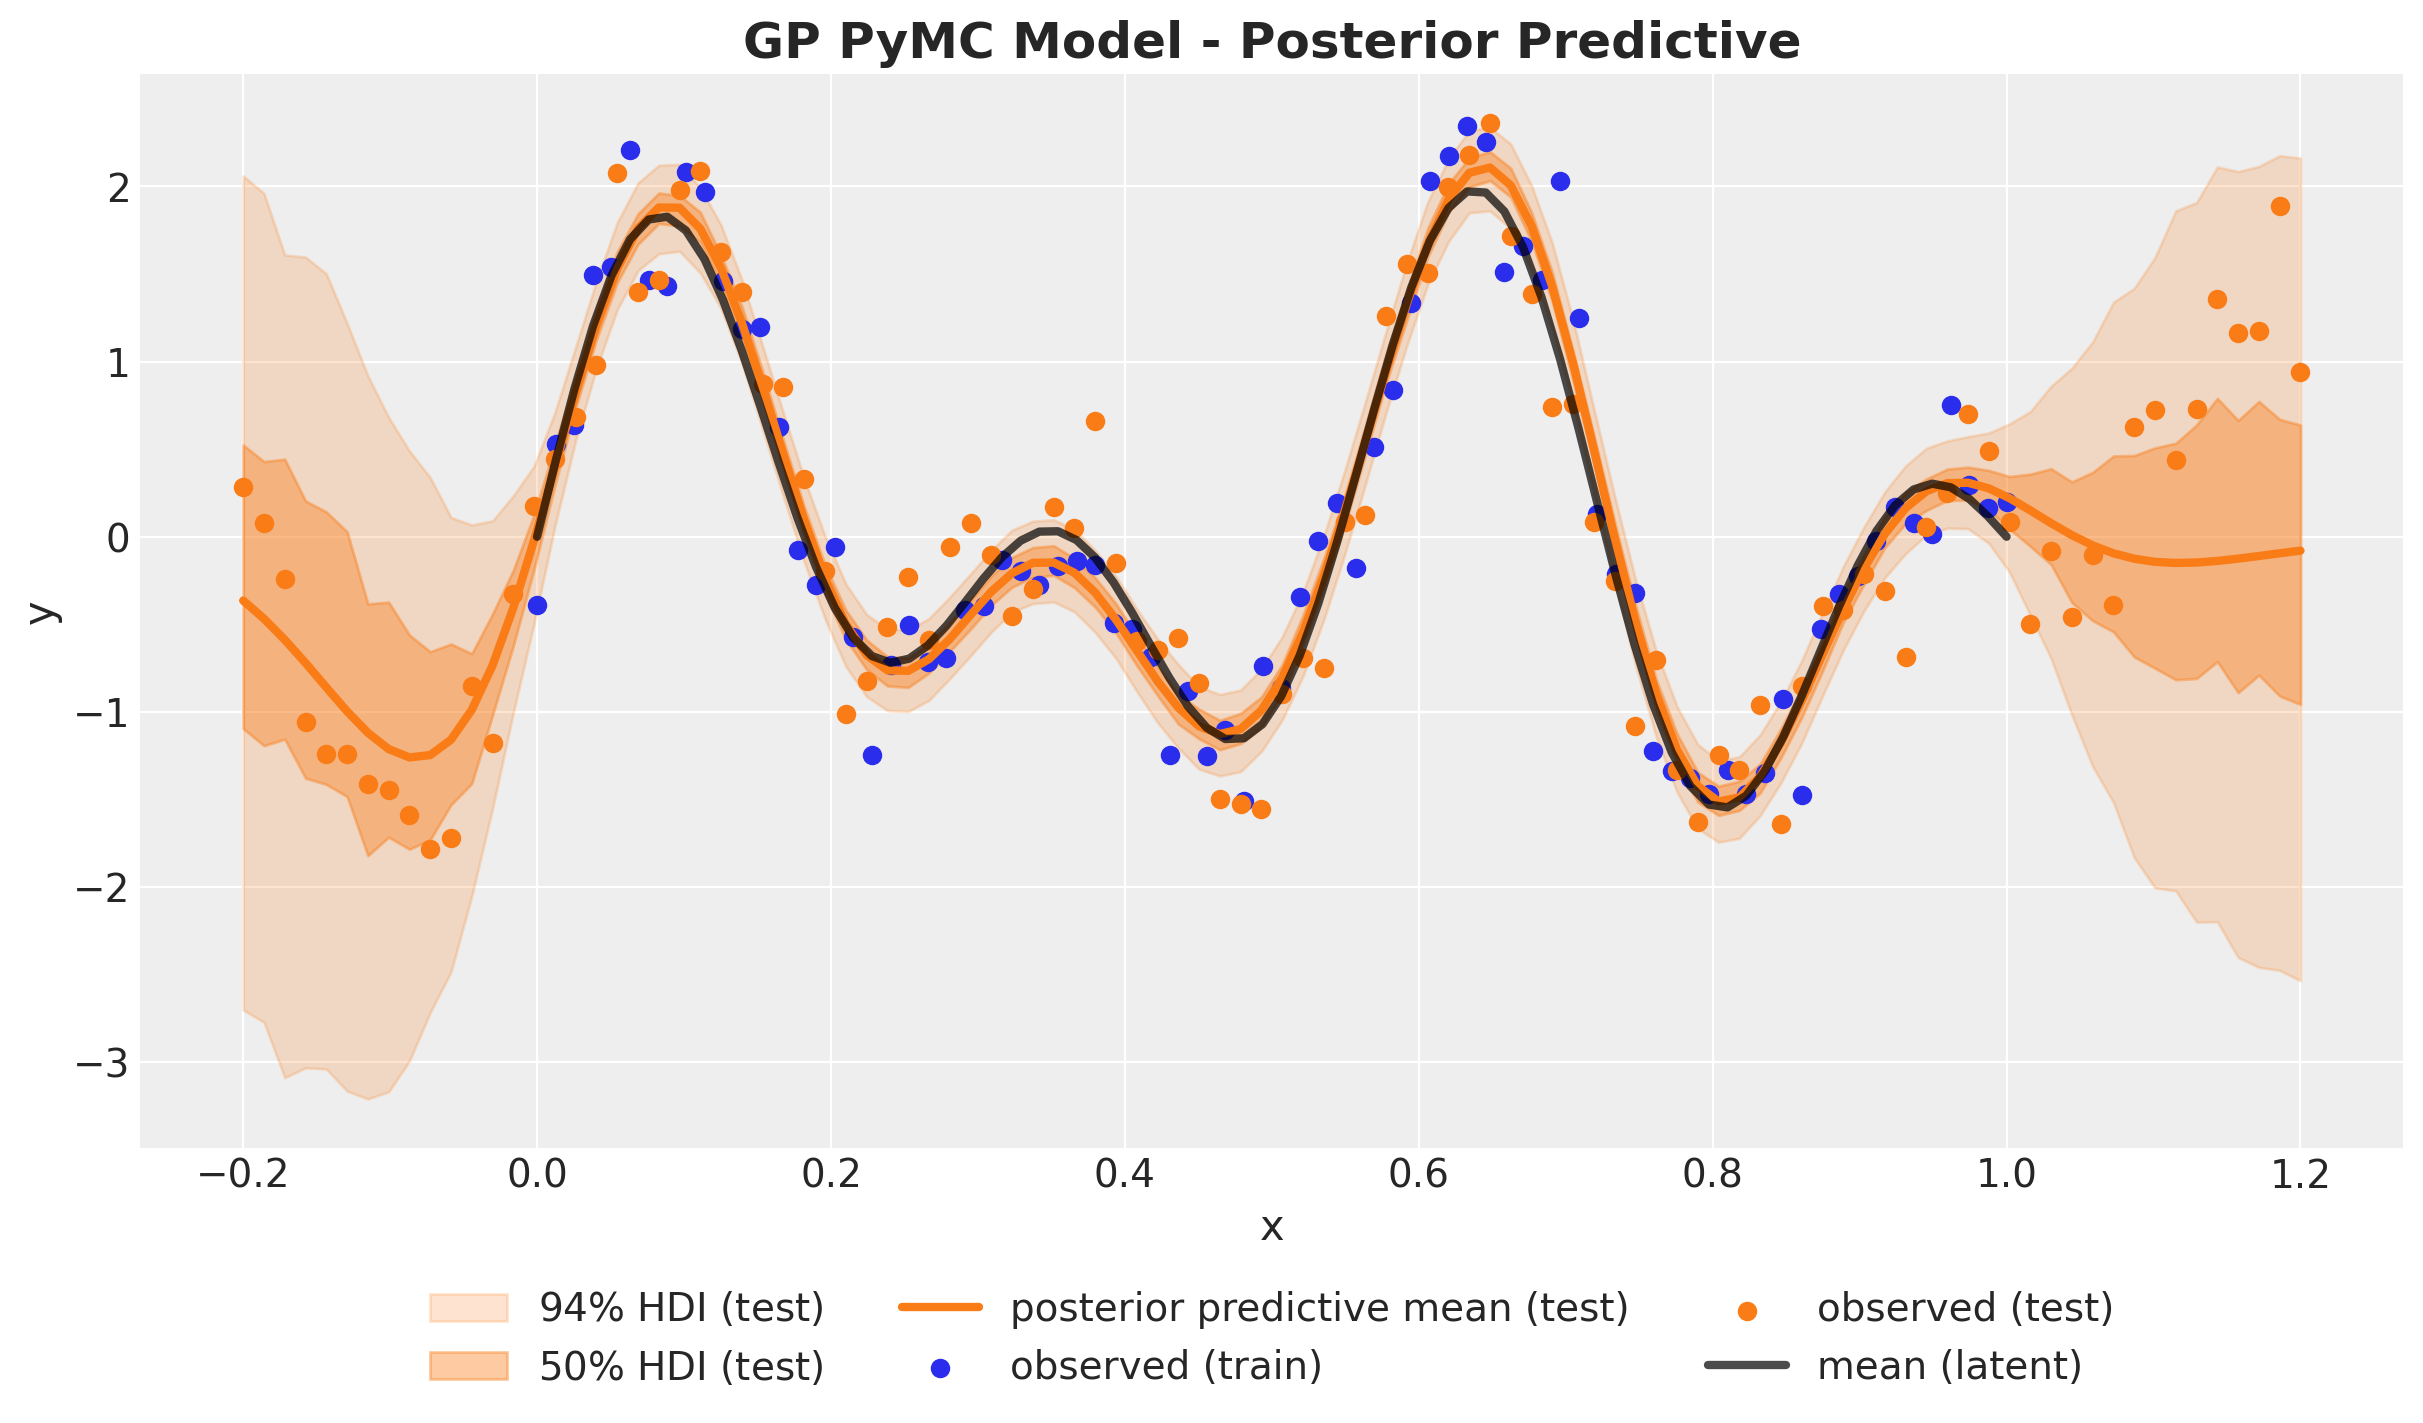

In [22]:
fig, ax = plt.subplots()
az.plot_hdi(
    x_test,
    gp_pymc_idata.posterior_predictive["y_pred_test"],
    hdi_prob=0.94,
    color="C1",
    smooth=False,
    fill_kwargs={"alpha": 0.2, "label": "$94\\%$ HDI (test)"},
    ax=ax,
)
az.plot_hdi(
    x_test,
    gp_pymc_idata.posterior_predictive["y_pred_test"],
    hdi_prob=0.5,
    color="C1",
    smooth=False,
    fill_kwargs={"alpha": 0.4, "label": "$50\\%$ HDI (test)"},
    ax=ax,
)
ax.plot(
    x_test,
    gp_pymc_idata.posterior_predictive["y_pred_test"].mean(dim=("chain", "draw")),
    color="C1",
    linewidth=3,
    label="posterior predictive mean (test)",
)
ax.scatter(x_train, y_train_obs, c="C0", label="observed (train)")
ax.scatter(x_test, y_test_obs, c="C1", label="observed (test)")
ax.plot(x_train, y_train, color="black", linewidth=3, alpha=0.7, label="mean (latent)")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3)
ax.set(xlabel="x", ylabel="y")
ax.set_title("GP PyMC Model - Posterior Predictive", fontsize=18, fontweight="bold")

Text(0.5, 1.05, 'GP - Posterior Distributions - NumPyro & PyMC Models')

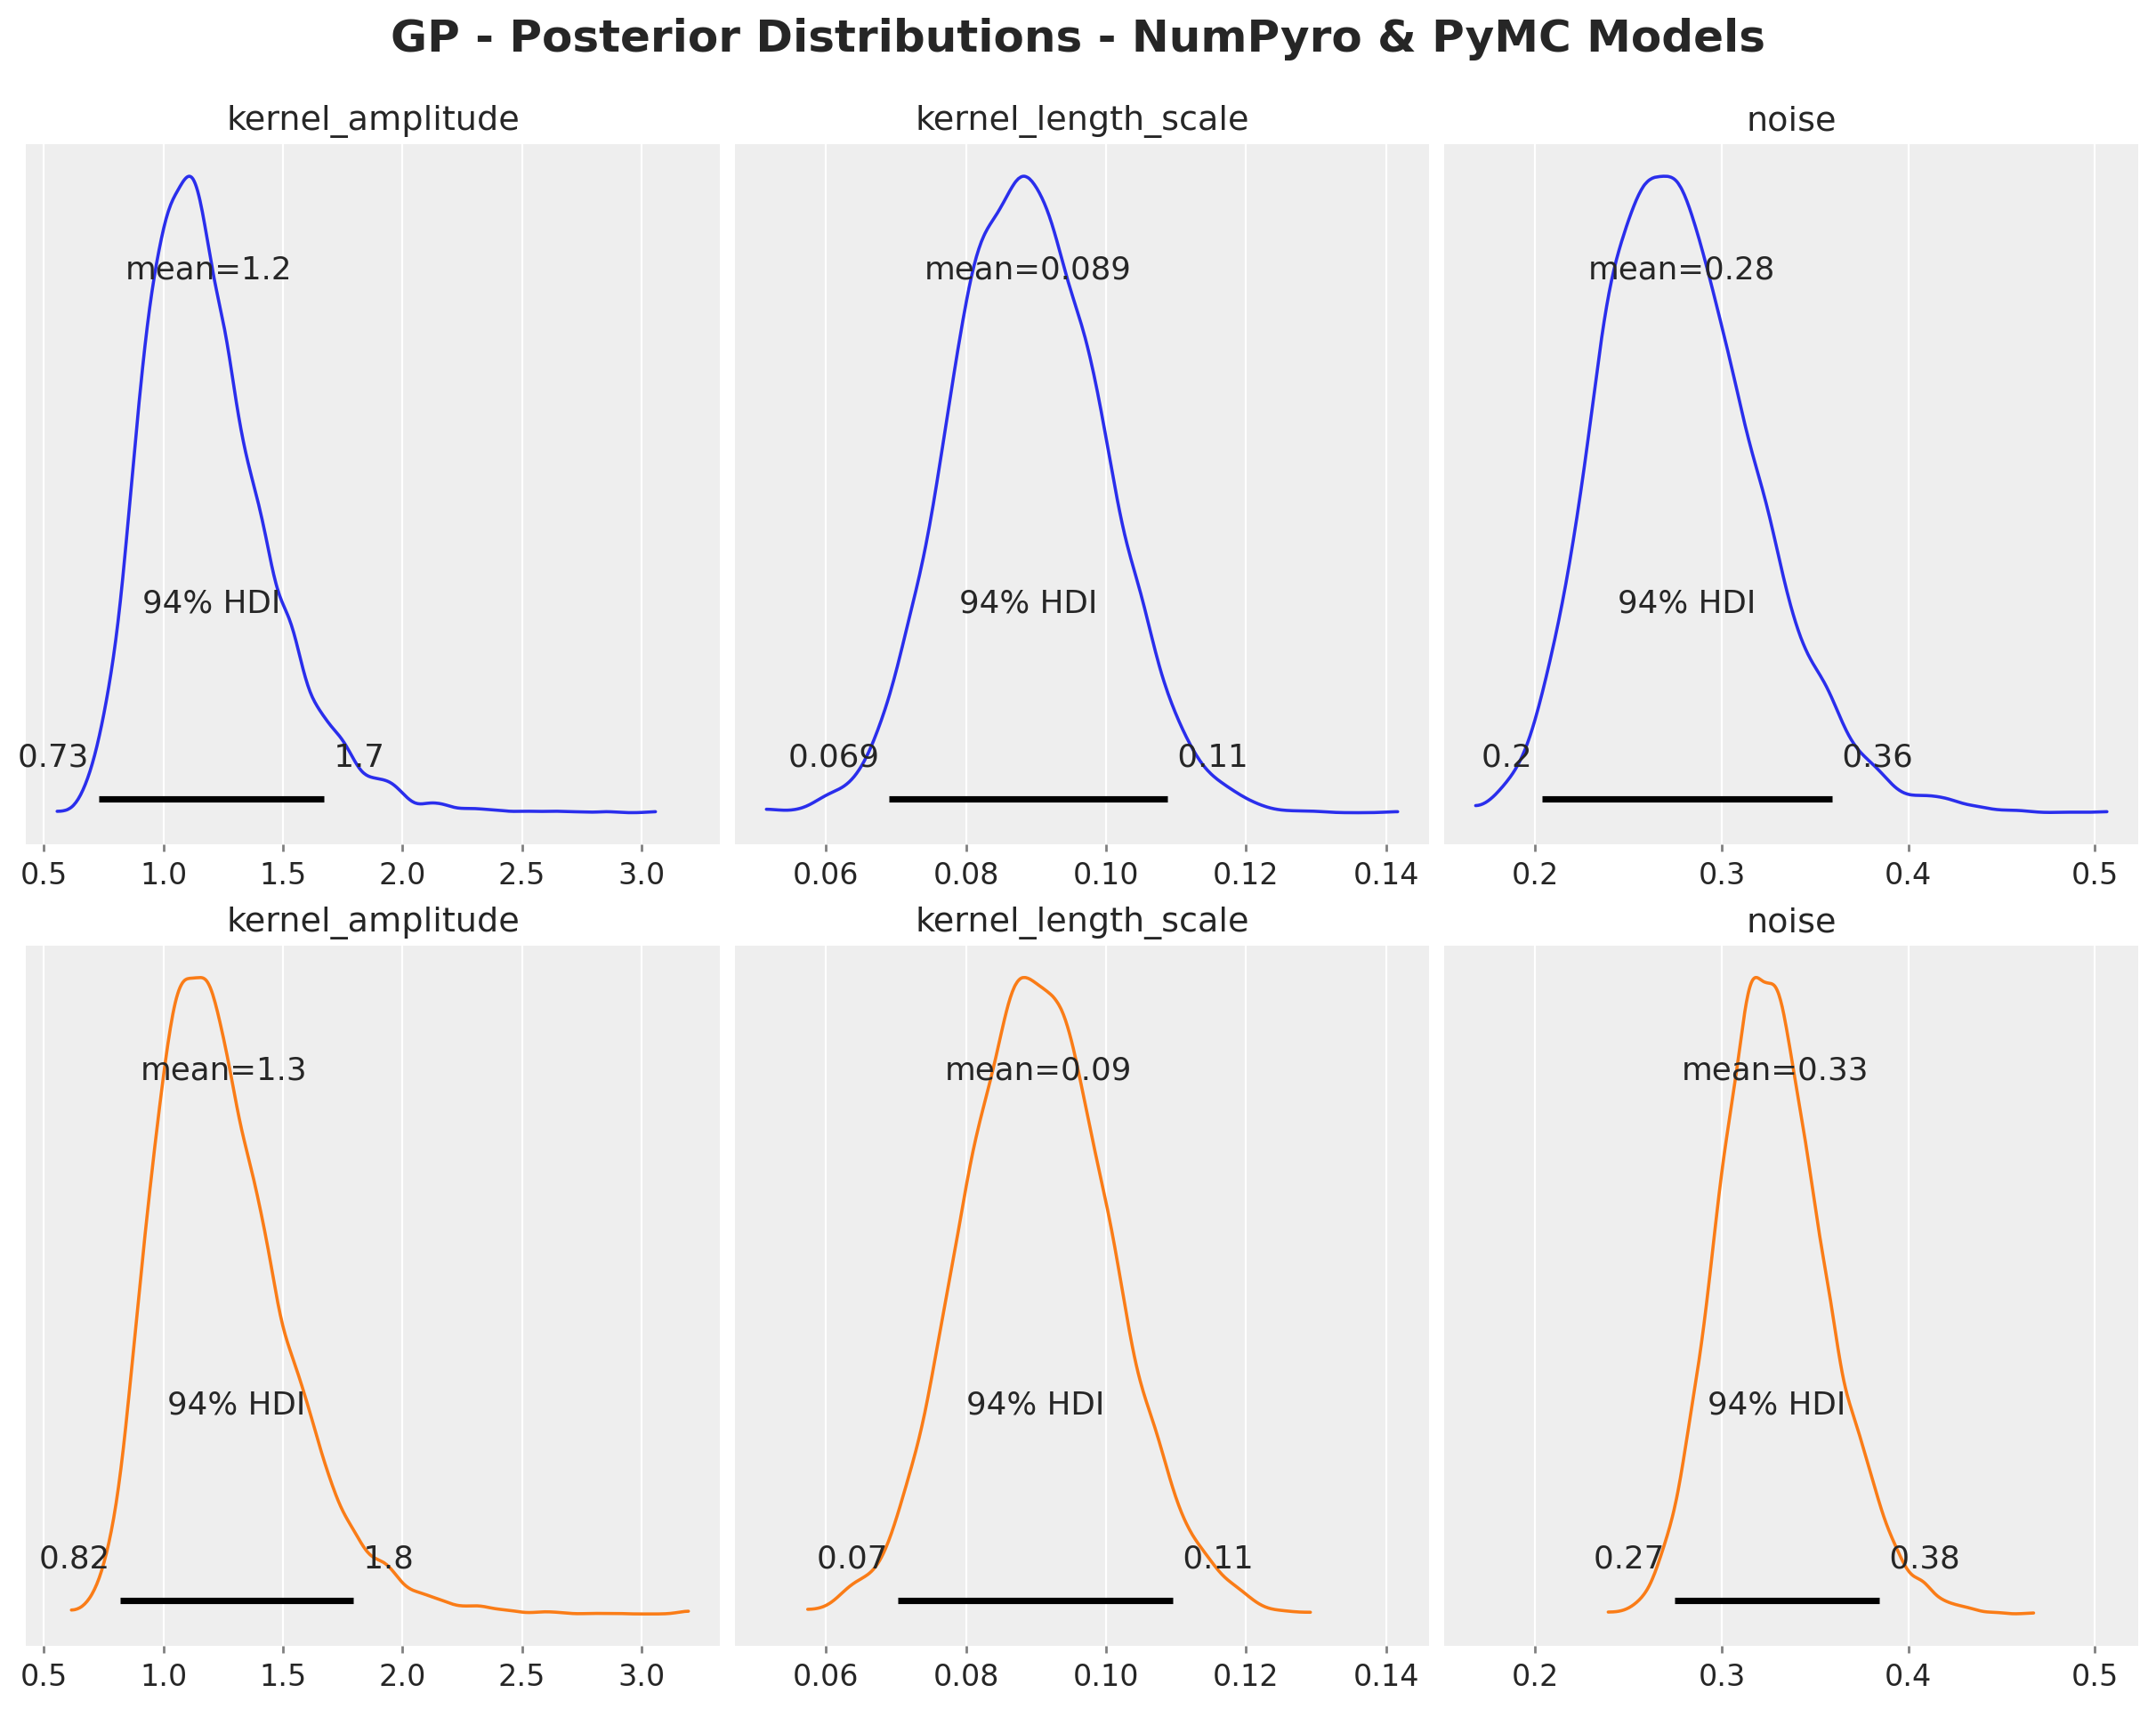

In [23]:
fig, ax = plt.subplots(
    nrows=2,
    ncols=3,
    figsize=(12, 9),
    sharex="col",
    sharey=False,
    constrained_layout=True,
)

az.plot_posterior(
    data=gp_numpyro_idata,
    var_names=["kernel_amplitude", "kernel_length_scale", "noise"],
    round_to=2,
    kind="kde",
    hdi_prob=0.94,
    color="C0",
    textsize=12,
    ax=ax[0, :],
)
az.plot_posterior(
    data=gp_pymc_idata,
    var_names=["kernel_amplitude", "kernel_length_scale", "noise"],
    round_to=2,
    kind="kde",
    hdi_prob=0.94,
    color="C1",
    textsize=12,
    ax=ax[1, :],
)
fig.suptitle(
    "GP - Posterior Distributions - NumPyro & PyMC Models",
    fontsize=18,
    fontweight="bold",
    y=1.05,
)

---

# Part II: Hilbert Space Gaussian Processes (HSGPs)